In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
from datetime import datetime
import os
import re
import matplotlib # Graphical Visualisation
import matplotlib.pyplot as plt
import matplotlib.dates as pltdt
import matplotlib.image as mpimg
import matplotlib.patches
from math import sqrt,pi,sin,cos,atan2
from sklearn import linear_model
from sklearn import metrics

In [2]:
# Importing Data

In [3]:
df = pd.read_csv('scraps4.csv')
df.head()

id                                              title  \
0  2707    Vente maison 88 m² Bouguenais (44340) 285.000 €   
1  2706  Vente appartement 4 pièces 89 m² Nantes (44300...   
2  2705  Vente appartement 5 pièces 76 m² Orvault (4470...   
3  2704  Vente appartement 2 pièces 44 m² Nantes (44300...   
4  2703  Vente appartement 4 pièces 156 m² Nantes (4400...   

                                                link      price  \
0  https://www.pap.fr/annonces/maison-bouguenais-...  285.000 €   
1  https://www.pap.fr/annonces/appartement-nantes...  330.000 €   
2  https://www.pap.fr/annonces/appartement-orvaul...  252.000 €   
3  https://www.pap.fr/annonces/appartement-nantes...  165.000 €   
4  https://www.pap.fr/annonces/appartement-nantes...  640.000 €   

                       ref_n_date                city  \
0  Réf. : D80/1598 / 26 juin 2021  Bouguenais (44340)   
1  Réf. : D78/3033 / 24 juin 2021      Nantes (44000)   
2  Réf. : D79/2025 / 19 juin 2021     Orvault (44700)   
3  Réf. : D79/1280 / 24 juin 2021      Nantes (44000)   
4  Réf. : D76/2589 / 28 juin 2021      Nantes (44000)   

                                                tags  \
0  4 pièces 3 chambres 88 m² Terrain 330 m² 3.239...   
1            4 pièces 2 chambres 89 m² 3.708 € le m²   
2            5 pièces 3 chambres 76 m² 3.316 € le m²   
3             2 pièces 1 chambre 44 m² 3.750 € le m²   
4           4 pièces 3 chambres 156 m² 4.103 € le m²   

                                           free_text  transport  \
0  Bouguenais (44340) 4 pièces 3 chambres 88 m² T...        NaN   
1  Nantes (44000) 4 pièces 2 chambres 89 m² 3.708...        NaN   
2  Orvault (44700) 5 pièces 3 chambres 76 m² 3.31...        NaN   
3  Nantes (44000) 2 pièces 1 chambre 44 m² 3.750 ...        NaN   
4  Nantes (44000) 4 pièces 3 chambres 156 m² 4.10...        NaN   

                                          raw_loc                   createdAt  \
0  {"center":["47.164128","-1.572825"],"zoom":15}  2021-06-29 22:54:11.826+02   
1  {"center":["47.231770","-1.524632"],"zoom":15}  2021-06-29 22:52:13.265+02   
2  {"center":["47.245932","-1.580090"],"zoom":15}  2021-06-29 22:52:03.165+02   
3  {"center":["47.239382","-1.513725"],"zoom":15}  2021-06-29 22:51:35.744+02   
4  {"center":["47.215579","-1.564950"],"zoom":15}  2021-06-29 22:49:31.313+02   

                    updatedAt  
0  2021-06-29 22:54:11.826+02  
1  2021-06-29 22:52:13.265+02  
2  2021-06-29 22:52:03.165+02  
3  2021-06-29 22:51:35.744+02  
4  2021-06-29 22:49:31.313+02

In [4]:
# Cleaning Data

In [5]:
len(df)

2643

In [6]:
df = df.drop(columns='id')

df['raw_loc'] = df['raw_loc'].map(lambda x : x.lstrip('{"center":['))
df['raw_loc'] = df['raw_loc'].map(lambda x : x.rstrip('],"zoom":15}'))
df['lat'] = df['raw_loc'].map(lambda x : x.split(',')[0])
df['long'] = df['raw_loc'].map(lambda x : x.split(',')[1])

df = df.drop(columns=['raw_loc'])

df['lat'] = df['lat'].map(lambda x : x.rstrip('"'))
df['long'] = df['long'].map(lambda x : x.lstrip('"'))
df['long'] = df['long'].map(lambda x : x.replace(']', ''))
df['lat'] = pd.to_numeric(df['lat'])
df['long'] = pd.to_numeric(df['long'])

df['tags'] = df['tags'].map(lambda x : x.replace('\n\n\n', ','))
df['tags'] = df['tags'].map(lambda x : x.replace('\n\n', ''))


df['ref'] = df['ref_n_date'].map(lambda x : x.split(' / ')[0])
df['date'] = df['ref_n_date'].map(lambda x : x.split(' / ')[1])

df = df.drop(columns=['ref_n_date'])

df = df.drop_duplicates(subset=['ref'], keep='last')

df['price'] = df['price'].map(lambda x : x.replace('.', ''))
df['price'] = df['price'].map(lambda x : x.rstrip(' €'))
df['price'] = df['price'].map(lambda x : x.rstrip())
df['price'] = pd.to_numeric(df['price'])

df['free_text'] = df['free_text'].apply(lambda x : x.rstrip(" Une erreur est survenue. Veuillez essayer de nouveau. Votre prénom Veuillez indiquer votre prénom. Ce prénom est trop long. Votre nom Veuillez indiquer votre nom. Ce nom est trop long. Votre e-mail Veuillez indiquer votre adresse e-mail. Cette adresse e-mail est incorrecte. Cette adresse e-mail est trop longue. Votre téléphone Veuillez saisir votre numéro de téléphone. Ce numéro de téléphone est incorrect. Votre message (pensez à donner des précisions sur votre recherche et sur votre plan de financement : emprunt, accord de principe de la banque, revente d'un bien...) / caractères Veuillez indiquer un message. Ce message est trop long. Envoi en cours... Message envoyé avec succès ! J'autorise pap.fr à collecter, traiter et transmettre ces données à l'annonceur. En savoir plus Votre prénom Veuillez indiquer votre prénom. Ce prénom est trop long. Votre nom Veuillez indiquer votre nom. Ce nom est trop long. Votre e-mail Veuillez indiquer votre adresse e-mail. Cette adresse e-mail est incorrecte. Cette adresse e-mail est trop longue. Votre téléphone Veuillez saisir votre numéro de téléphone. Ce numéro de téléphone est incorrect. Votre message (pensez à donner des précisions sur votre recherche et sur votre plan de financement : emprunt, accord de principe de la banque, revente d'un bien...) / caractères Veuillez indiquer un message. Ce message est trop long. Simulation de financement Prix du bien : Prix + Frais de notaire (indicatif) : Apport personnel : L'apport personnel doit être un entier Emprunt : Veuillez indiquer un montant d'emprunt Taux d'intérêt* : Veuillez indiquer un taux. Taux d'assurance* : Durée Mensualité Coût de l'emprunt 10 15 20 25 30 Comparer les offres de financement Prix du bien : Prix + Frais de notaire (indicatif) : Taux d'intérêt* : Veuillez indiquer un taux. Taux d'assurance* :"))

df = df.reset_index(drop=True)

In [7]:
pieces = []
chambre = []
sqrt_mtr = []

i = 0
while i <= len(df)-1:
    ext = df['tags'][i]
    pieces_toadd = ''    
    chambre_toadd = ''
    sqrt_mtr_toadd = ''
    
    try :
        pieces_toadd = re.findall('(\d+)[^\d]+pièce[s]?', ext)[0]
    except :
        pieces_toadd = ''
    
    try :
        chambre_toadd = re.findall('(\d+)[^\d]+chambre[s]?', ext)[0]
    except : 
        chambre_toadd = ''
        
    try : 
        sqrt_mtr_toadd = re.findall('(\d+)[^\d]+m²', ext)[0]
    except : 
        sqrt_mtr_toadd = ''
    
    if pieces_toadd == '':
        pieces.append('')
    else:
        pieces.append(pieces_toadd)
    
    if chambre_toadd == '':
        chambre.append('')
    else:
        chambre.append(chambre_toadd)
        
    if sqrt_mtr_toadd == '':
        sqrt_mtr.append('')
    else:
        sqrt_mtr.append(sqrt_mtr_toadd)
        
    i = i + 1

df['pieces'] = pieces
df['chambre'] = chambre
df['sqrt_meter'] = sqrt_mtr

df = df.drop(columns=['tags'])

df['price'] = pd.to_numeric(df['price'])
df['sqrt_meter'] = pd.to_numeric(df['sqrt_meter'])
df['pieces'] = pd.to_numeric(df['pieces'])
df['chambre'] = pd.to_numeric(df['chambre'])

df['mean_price_sqrtmtr'] = df['price'] / df['sqrt_meter']

In [8]:
marque_1 = []
cave = []
balcon = []
parking = []
chambre = []

x = 0
while x <= len(df)-1:
    ft1 = ''
    ft1 = df['free_text'][x]
    ft1 = str(ft1)
    c = re.findall('étage | etage', ft1.lower())#[0].title())
    if not c:
        marque_1.append(0)
    else:
        marque_1.append(1)
        
    ft2 = ''
    ft2 = df['free_text'][x]
    ft2 = str(ft2)
    c = re.findall('cave', ft2.lower())#[0].title())
    if not c:
        cave.append(0)
    else:
        cave.append(1)
        
    ft3 = ''
    ft3 = df['free_text'][x]
    ft3 = str(ft3)
    c = re.findall('balcon | terrasse', ft3.lower())#[0].title())
    if not c:
        balcon.append(0)
    else:
        balcon.append(1)
        
    ft4 = ''
    ft4 = df['free_text'][x]
    ft4 = str(ft4)
    c = re.findall('chambre', ft4.lower())#[0].title())
    if not c:
        chambre.append(0)
    else:
        chambre.append(1)
        
    ft5 = ''
    ft5 = df['free_text'][x]
    ft5 = str(ft5)
    c = re.findall('parking', ft5.lower())#[0].title())
    if not c:
        parking.append(0)
    else:
        parking.append(1)
    
    x = x +1
    
df['cave'] = cave
df['balcon'] = balcon
df['parking'] = parking
df['chambre'] = chambre

In [9]:
def calculate_distance(x, y):
    xa = x
    ya = y
    xb = 2.256520
    yb = 48.896801
    r = 6371e3
    
    a1 = xa * pi/180
    a2 = xb * pi/180
    v1 = (xb-xa) * pi/180
    v2 = (yb-ya) * pi/180
    
    a = sin(v1/2) * sin(v1/2) +cos(a1) * cos(a2) * sin(v2/2) * sin(v2/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = (r * c) / 1000

    return d

distance = []
x = 0
while x <= len(df)-1:
    a = calculate_distance(df['long'][x], df['lat'][x])
    
    distance.append(a)
    x = x + 1
    
df['distance'] = distance

In [10]:
def text_to_date(x):
    day = int(x[0:2])
    month = x[3:-5]
    
    if month == 'mai':
        mth = 5
    elif month == 'août':
        mth = 8
    elif month == 'juin':
        mth = 6
    
    year = int(x[-4:])
    
    date = datetime(year, mth, day)
    date = date.strftime('%d/%m/%Y')
    
    return date

In [11]:
df['code-postal'] = df['city'].apply(lambda x : x[-8:])
df['code-postal'] = df['code-postal'].apply(lambda x : x.replace('(', ''))
df['code-postal'] = df['code-postal'].apply(lambda x : x.replace(')', ''))
df['city'] = df['city'].apply(lambda x : x[:-8])
df['date'] = df['date'].apply(lambda x : text_to_date(x))
#df['date'] = pd.to_numeric(df['date'])
df['sqrt_meter'] = pd.to_numeric(df['sqrt_meter'], downcast='integer')
df['sqrt_meter'] = df['sqrt_meter'].fillna(0)
df['sqrt_meter'] = df['sqrt_meter'].apply(lambda x : int(x))

df = df.loc[df['price'] > 0 ,:]
df = df.loc[df['sqrt_meter'] > 0 ,:]
df = df.reset_index(drop=True)

In [12]:
df['price'].value_counts()

320000     10
255000      8
395000      7
225000      7
390000      7
           ..
160000      1
1580000     1
459000      1
1985000     1
1130000     1
Name: price, Length: 325, dtype: int64

In [13]:
df.head()

title  \
0    Vente maison 88 m² Bouguenais (44340) 285.000 €   
1  Vente appartement 3 pièces 66 m² Nantes (44000...   
2  Vente appartement 2 pièces 62 m² Nantes (44000...   
3  Vente appartement 3 pièces 57 m² Nantes (44000...   
4  Vente appartement 3 pièces 89 m² Nantes (44000...   

                                                link   price        city  \
0  https://www.pap.fr/annonces/maison-bouguenais-...  285000  Bouguenais   
1  https://www.pap.fr/annonces/appartement-nantes...  250000      Nantes   
2  https://www.pap.fr/annonces/appartement-nantes...  260000      Nantes   
3  https://www.pap.fr/annonces/appartement-nantes...  276000      Nantes   
4  https://www.pap.fr/annonces/appartement-nantes...  400000      Nantes   

                                           free_text  transport  \
0  Bouguenais (44340) 4 pièces 3 chambres 88 m² T...        NaN   
1  Nantes (44000) 3 pièces 2 chambres 66 m² 3.788...        NaN   
2  Nantes (44000) 2 pièces 1 chambre 62 m² 4.194 ...        NaN   
3  Nantes (44000) 3 pièces 2 chambres 57 m² 4.842...        NaN   
4  Nantes (44000) 3 pièces 2 chambres 89 m² 4.494...        NaN   

                    createdAt                   updatedAt        lat  \
0  2021-06-29 22:54:11.826+02  2021-06-29 22:54:11.826+02  47.164128   
1  2021-06-29 22:49:15.028+02  2021-06-29 22:49:15.028+02   0.000000   
2  2021-06-29 22:49:10.891+02  2021-06-29 22:49:10.891+02  47.221568   
3  2021-06-29 22:49:06.735+02  2021-06-29 22:49:06.735+02  47.222167   
4  2021-06-29 22:48:58.579+02  2021-06-29 22:48:58.579+02  47.218043   

       long  ...        date pieces  chambre  sqrt_meter  mean_price_sqrtmtr  \
0 -1.572820  ...  26/06/2021    4.0        1          88         3238.636364   
1  0.000000  ...  29/06/2021    3.0        1          66         3787.878788   
2 -1.566400  ...  29/06/2021    2.0        1          62         4193.548387   
3 -1.556663  ...  29/06/2021    3.0        1          57         4842.105263   
4 -1.548062  ...  29/06/2021    3.0        1          89         4494.382022   

   cave  balcon  parking     distance  code-postal  
0     0       1        0   467.346549        44340  
1     1       1        1  5441.385126        44000  
2     0       0        0   464.097038        44000  
3     1       0        1   463.078795        44000  
4     0       1        0   462.388151        44000  

[5 rows x 21 columns]

In [14]:
# EDA

<i>Creating Dataset based on City level</i>

In [15]:
city_general_characteristics = pd.DataFrame({
    "city" : [],
    "count" : [],
    "mean_sqrt_meter" : [],
    "min_sqrt_meter" : [],
    "max_sqrt_meter" : [],
    "median_sqrt_meter" : [],
    "mean_price" : [],
    "min_price" : [],
    "max_price" : [],
    "median_price" : [],
    "mean_price_sqrtmtr" : []
})

count = df['city'].count()
mean_sqrt_meter = df['sqrt_meter'].mean()
min_sqrt_meter = df['sqrt_meter'].min()
max_sqrt_meter = df['sqrt_meter'].max()
median_sqrt_meter = df['sqrt_meter'].median()
mean_price = df['price'].mean()
min_price = df['price'].min()
max_price = df['price'].max()
median_price = df['price'].median()
mean_price_sqrt = df['mean_price_sqrtmtr'].mean()

r = city_general_characteristics.shape[0]
city_general_characteristics.loc[r] = ['General',count,mean_sqrt_meter,min_sqrt_meter,max_sqrt_meter,median_sqrt_meter,mean_price,min_price,max_price,median_price, mean_price_sqrt]

for x in set(df['city']):
    temp = df.loc[df['city']==x,:]
    
    city = x
    
    count = temp['city'].count()
    mean_sqrt_meter = temp['sqrt_meter'].mean()
    min_sqrt_meter = temp['sqrt_meter'].min()
    max_sqrt_meter = temp['sqrt_meter'].max()
    median_sqrt_meter = temp['sqrt_meter'].median()
    mean_price = temp['price'].mean()
    min_price = temp['price'].min()
    max_price = temp['price'].max()
    median_price = temp['price'].median()
    mean_price_sqrt = temp['mean_price_sqrtmtr'].mean()
    
    r = city_general_characteristics.shape[0]
    city_general_characteristics.loc[r] = [city,count,mean_sqrt_meter,min_sqrt_meter,max_sqrt_meter,median_sqrt_meter,mean_price,min_price,max_price,median_price,mean_price_sqrt]
    
city_general_characteristics

city  count  mean_sqrt_meter  min_sqrt_meter  \
0                     General  688.0        71.808140             7.0   
1               Bois-Colombes   19.0        75.368421            33.0   
2           Neuilly-sur-Seine   75.0        70.373333             7.0   
3       Sainte-Luce-sur-Loire    2.0        99.000000            80.0   
4                      Bouaye    2.0        60.500000            26.0   
5                        Rezé    3.0        74.333333            57.0   
6                    Flourens    1.0       120.000000           120.0   
7   Saint-Sébastien-sur-Loire    2.0        61.000000            42.0   
8         La Garenne-Colombes   33.0        75.333333            28.0   
9           Quint-Fonsegrives    1.0        78.000000            78.0   
10                    Couëron    1.0        94.000000            94.0   
11                 Courbevoie   88.0        69.102273            21.0   
12                    Cugnaux    2.0        91.000000            88.0   
13                    Puteaux   79.0        70.050633            13.0   
14      Ramonville-Saint-Agne    4.0        88.500000            63.0   
15           Levallois-Perret   90.0        62.144444            14.0   
16                La Montagne    2.0        76.500000            75.0   
17                 Aucamville    1.0        45.000000            45.0   
18             Saint-Herblain    4.0        92.500000            49.0   
19                    Ancenis    1.0       140.000000           140.0   
20         Asnières-sur-Seine   17.0        79.882353            34.0   
21                    Orvault    2.0       100.000000            75.0   
22                     Nantes   52.0        70.519231            18.0   
23                  Carquefou    1.0        68.000000            68.0   
24                   Colombes   15.0        73.666667            47.0   
25                 Bouguenais    1.0        88.000000            88.0   
26                      Balma    1.0       113.000000           113.0   
27                    Blagnac    6.0        89.833333            60.0   
28                   Toulouse  180.0        74.527778            16.0   
29                  Beauzelle    1.0       105.000000           105.0   
30                  Colomiers    1.0        44.000000            44.0   
31                     Vertou    1.0        98.000000            98.0   

    max_sqrt_meter  median_sqrt_meter     mean_price  min_price  max_price  \
0            175.0               70.0  505333.822674    60000.0  2500000.0   
1            175.0               63.0  616578.947368   253000.0  1399000.0   
2            162.0               68.0  871549.066667    99000.0  2500000.0   
3            118.0               99.0  347500.000000   305000.0   390000.0   
4             95.0               60.5  222500.000000   110000.0   335000.0   
5             91.0               75.0  239000.000000   172000.0   350000.0   
6            120.0              120.0  400000.000000   400000.0   400000.0   
7             80.0               61.0  252500.000000   185000.0   320000.0   
8            120.0               74.0  584363.636364   225000.0  1100000.0   
9             78.0               78.0  235000.000000   235000.0   235000.0   
10            94.0               94.0  270000.000000   270000.0   270000.0   
11           123.0               70.5  547698.863636   180000.0  1107000.0   
12            94.0               91.0  310000.000000   280000.0   340000.0   
13           142.0               68.0  586746.835443   175000.0  1269000.0   
14           105.0               93.0  290750.000000   215000.0   390000.0   
15           120.0               59.0  679355.555556   130000.0  1985000.0   
16            78.0               76.5  357500.000000   320000.0   395000.0   
17            45.0               45.0  135000.000000   135000.0   135000.0   
18           120.0              100.5  317500.000000   185000.0   455000.0   
19           140.0              140.0  280000.000000   

In [16]:
df.describe()

price  transport         lat        long      pieces  \
count  6.880000e+02        0.0  688.000000  688.000000  686.000000   
mean   5.053338e+05        NaN   45.835973    1.593086    3.148688   
std    3.304979e+05        NaN    8.240683    1.149475    1.124923   
min    6.000000e+04        NaN    0.000000   -1.694409    1.000000   
25%    2.700000e+05        NaN   43.619381    1.437850    2.000000   
50%    4.200000e+05        NaN   48.882761    2.240185    3.000000   
75%    6.400000e+05        NaN   48.895986    2.267542    4.000000   
max    2.500000e+06        NaN   48.930994    2.316743    5.000000   

          chambre  sqrt_meter  mean_price_sqrtmtr        cave      balcon  \
count  688.000000   688.00000          688.000000  688.000000  688.000000   
mean     0.930233    71.80814         7236.145622    0.542151    0.449128   
std      0.254940    29.07964         3310.524415    0.498583    0.497767   
min      0.000000     7.00000         1280.487805    0.000000    0.000000   
25%      1.000000    51.00000         4147.085777    0.000000    0.000000   
50%      1.000000    70.00000         7284.161491    1.000000    0.000000   
75%      1.000000    90.00000         9800.642479    1.000000    1.000000   
max      1.000000   175.00000        18048.780488    1.000000    1.000000   

          parking     distance  
count  688.000000   688.000000  
mean     0.523256   371.051536  
std      0.499822   915.940107  
min      0.000000     0.110202  
25%      0.000000     2.132080  
50%      1.000000     3.611636  
75%      1.000000   593.393001  
max      1.000000  5441.385126

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               688 non-null    object 
 1   link                688 non-null    object 
 2   price               688 non-null    int64  
 3   city                688 non-null    object 
 4   free_text           688 non-null    object 
 5   transport           0 non-null      float64
 6   createdAt           688 non-null    object 
 7   updatedAt           688 non-null    object 
 8   lat                 688 non-null    float64
 9   long                688 non-null    float64
 10  ref                 688 non-null    object 
 11  date                688 non-null    object 
 12  pieces              686 non-null    float64
 13  chambre             688 non-null    int64  
 14  sqrt_meter          688 non-null    int64  
 15  mean_price_sqrtmtr  688 non-null    float64
 16  cave    

In [18]:
# °reprocessing
df.isnull().sum()

title                   0
link                    0
price                   0
city                    0
free_text               0
transport             688
createdAt               0
updatedAt               0
lat                     0
long                    0
ref                     0
date                    0
pieces                  2
chambre                 0
sqrt_meter              0
mean_price_sqrtmtr      0
cave                    0
balcon                  0
parking                 0
distance                0
code-postal             0
dtype: int64

title : object
link : object


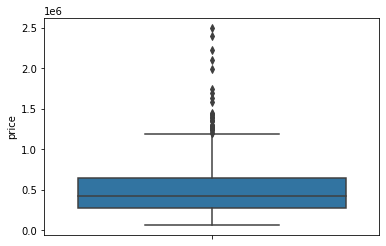

price : int64
city : object
free_text : object


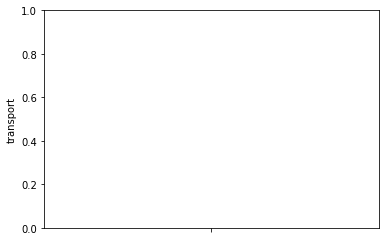

transport : float64
createdAt : object
updatedAt : object


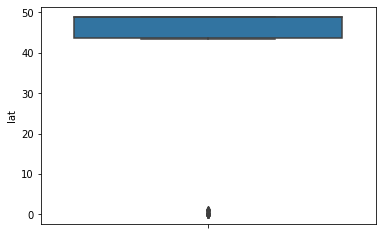

lat : float64


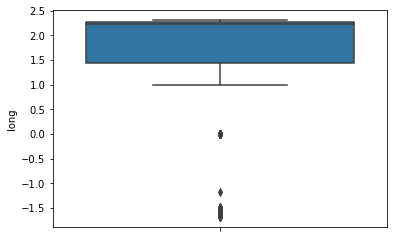

long : float64
ref : object
date : object


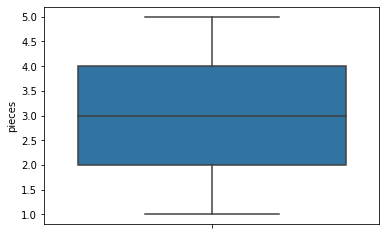

pieces : float64


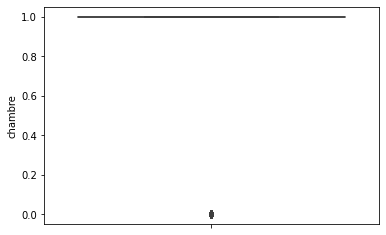

chambre : int64


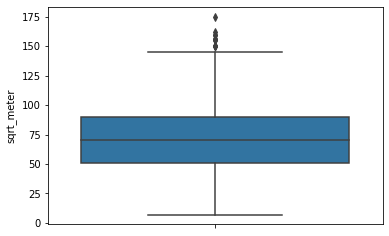

sqrt_meter : int64


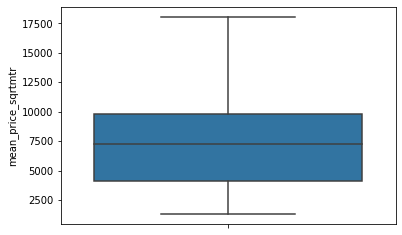

mean_price_sqrtmtr : float64


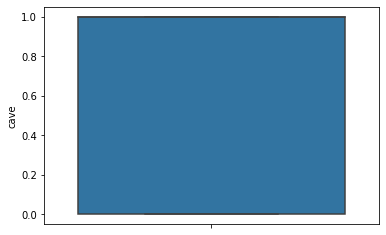

cave : int64


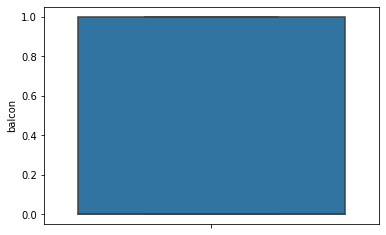

balcon : int64


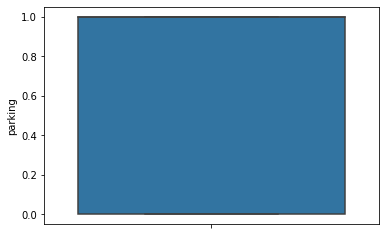

parking : int64


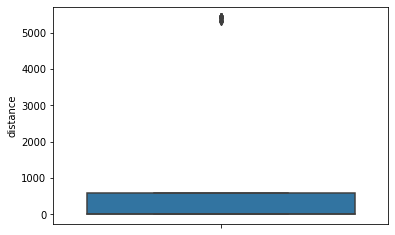

distance : float64
code-postal : object


In [19]:
# EDA 1
for column in df.columns:
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        sns.boxplot(y = df[column], data=df )
    plt.show()
    print(f'{column} : {df[column].dtype}')

<BarContainer object of 31 artists>

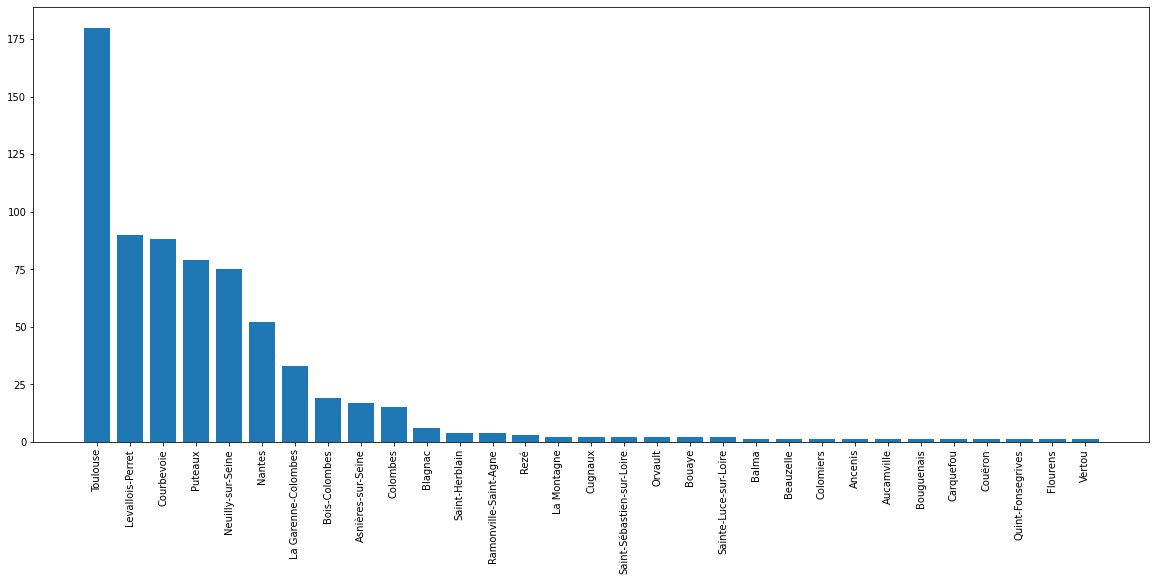

In [20]:
x = df['city'].value_counts().values
y = df['city'].value_counts().index

plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
plt.bar(y,x)

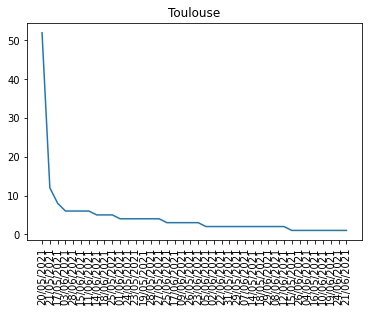

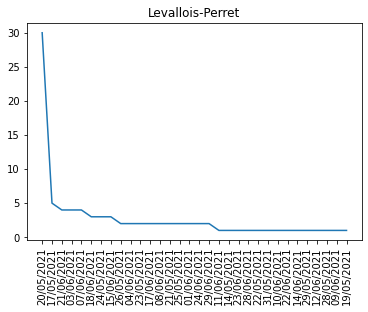

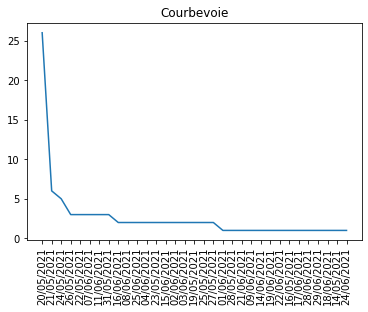

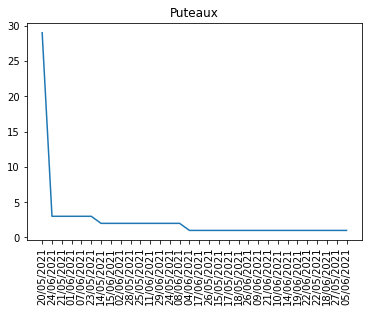

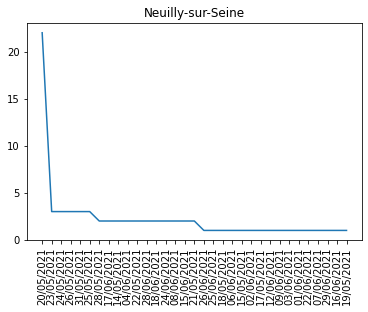

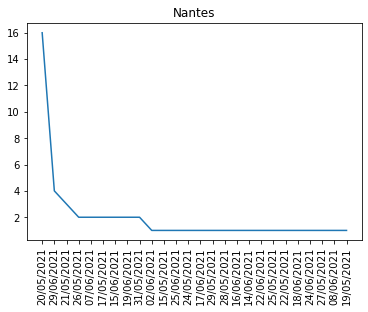

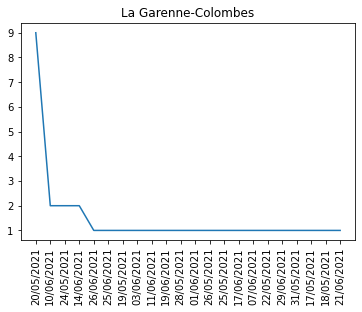

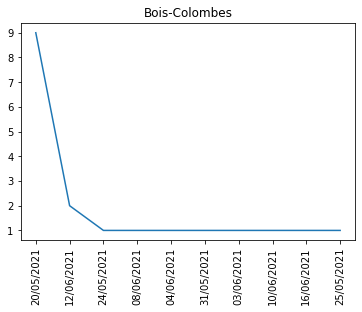

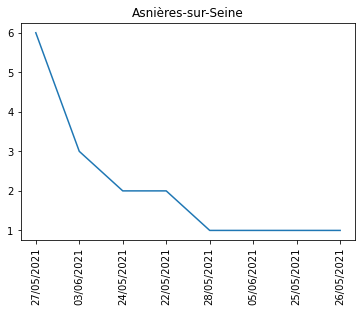

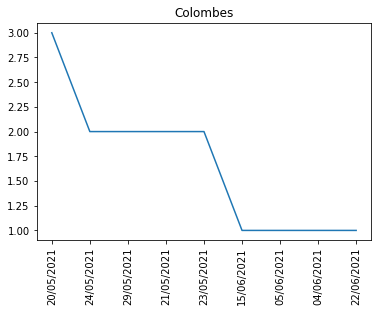

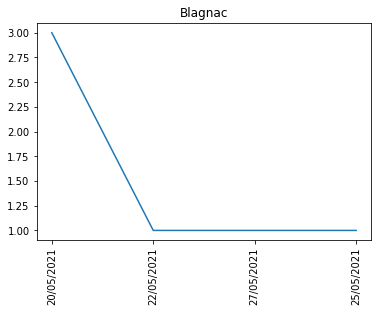

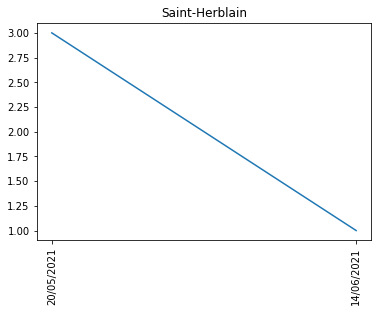

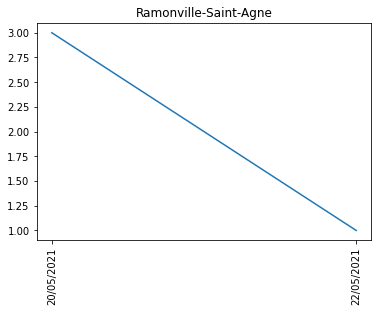

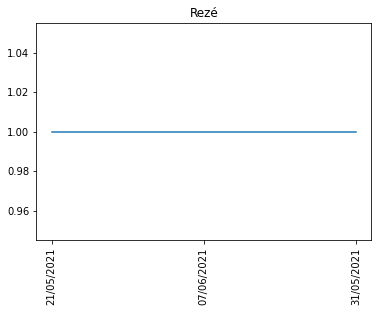

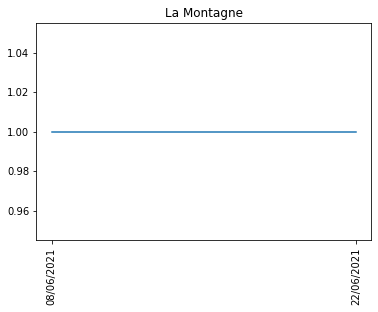

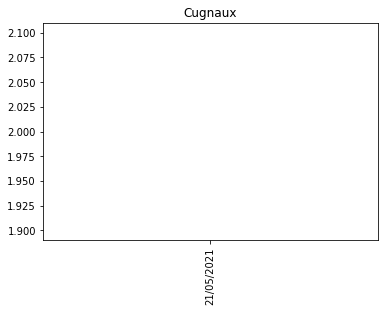

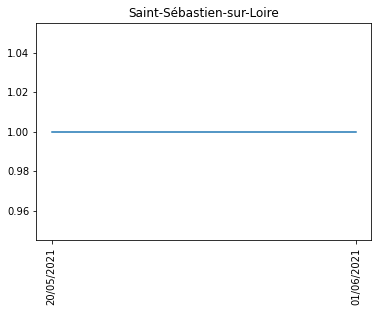

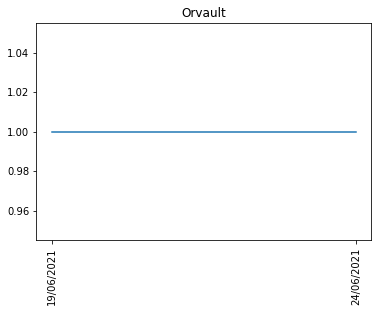

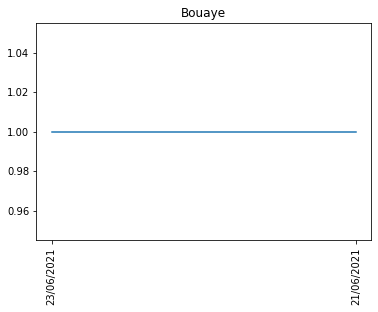

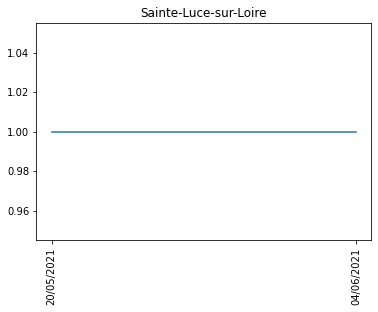

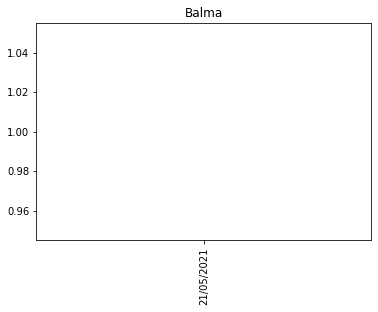

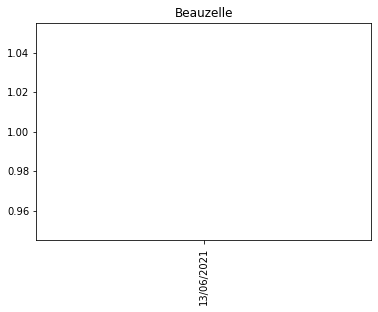

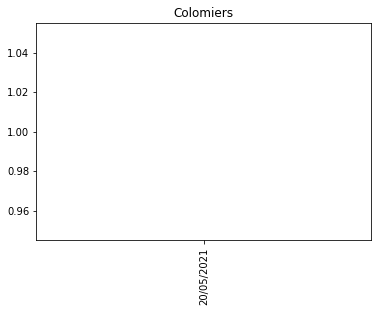

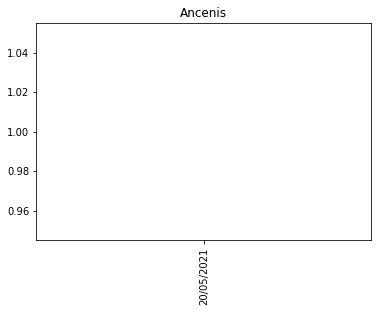

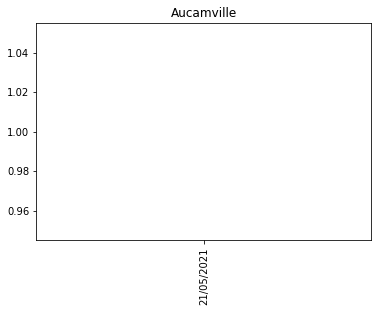

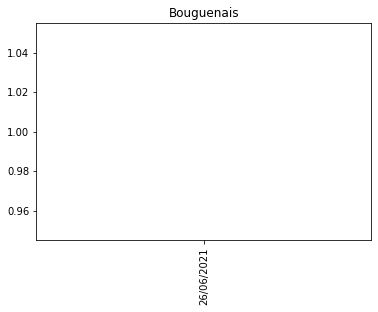

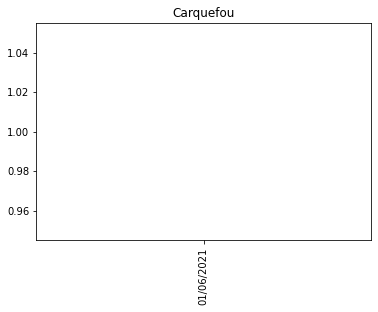

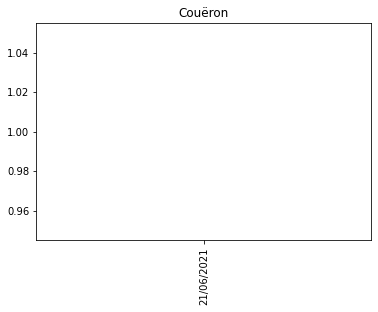

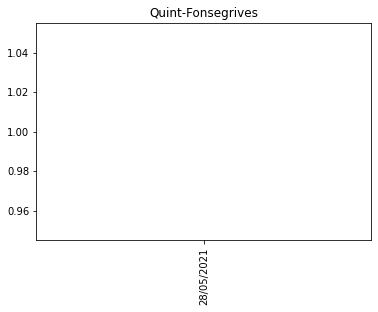

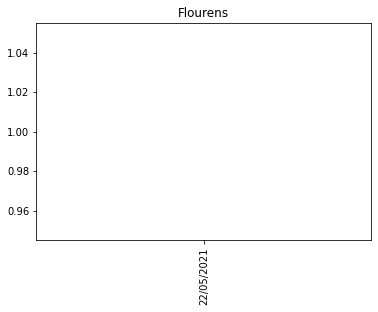

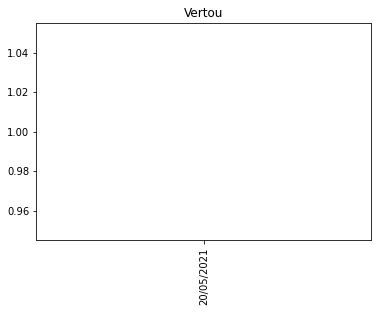

In [21]:
for city in df['city'].value_counts().index:
    scope = df.loc[df['city']==city,:]
    x = scope['date'].value_counts().index
    y = scope['date'].value_counts().values
    plt.plot(x,y)
    plt.title(city)
    plt.xticks(rotation=90)
    plt.show()

#fig, axes = plt.subplots(5, 5, figsize=(16, 8))

#for col, ax in zip(df.columns, axes.flatten()):
#    ax.bar(df.index, df[col])
#    ax.set_title(col)
#    plt.subplots_adjust(wspace=.5, hspace=.5)

In [22]:
df['date'].describe()

count            688
unique            44
top       20/05/2021
freq             210
Name: date, dtype: object

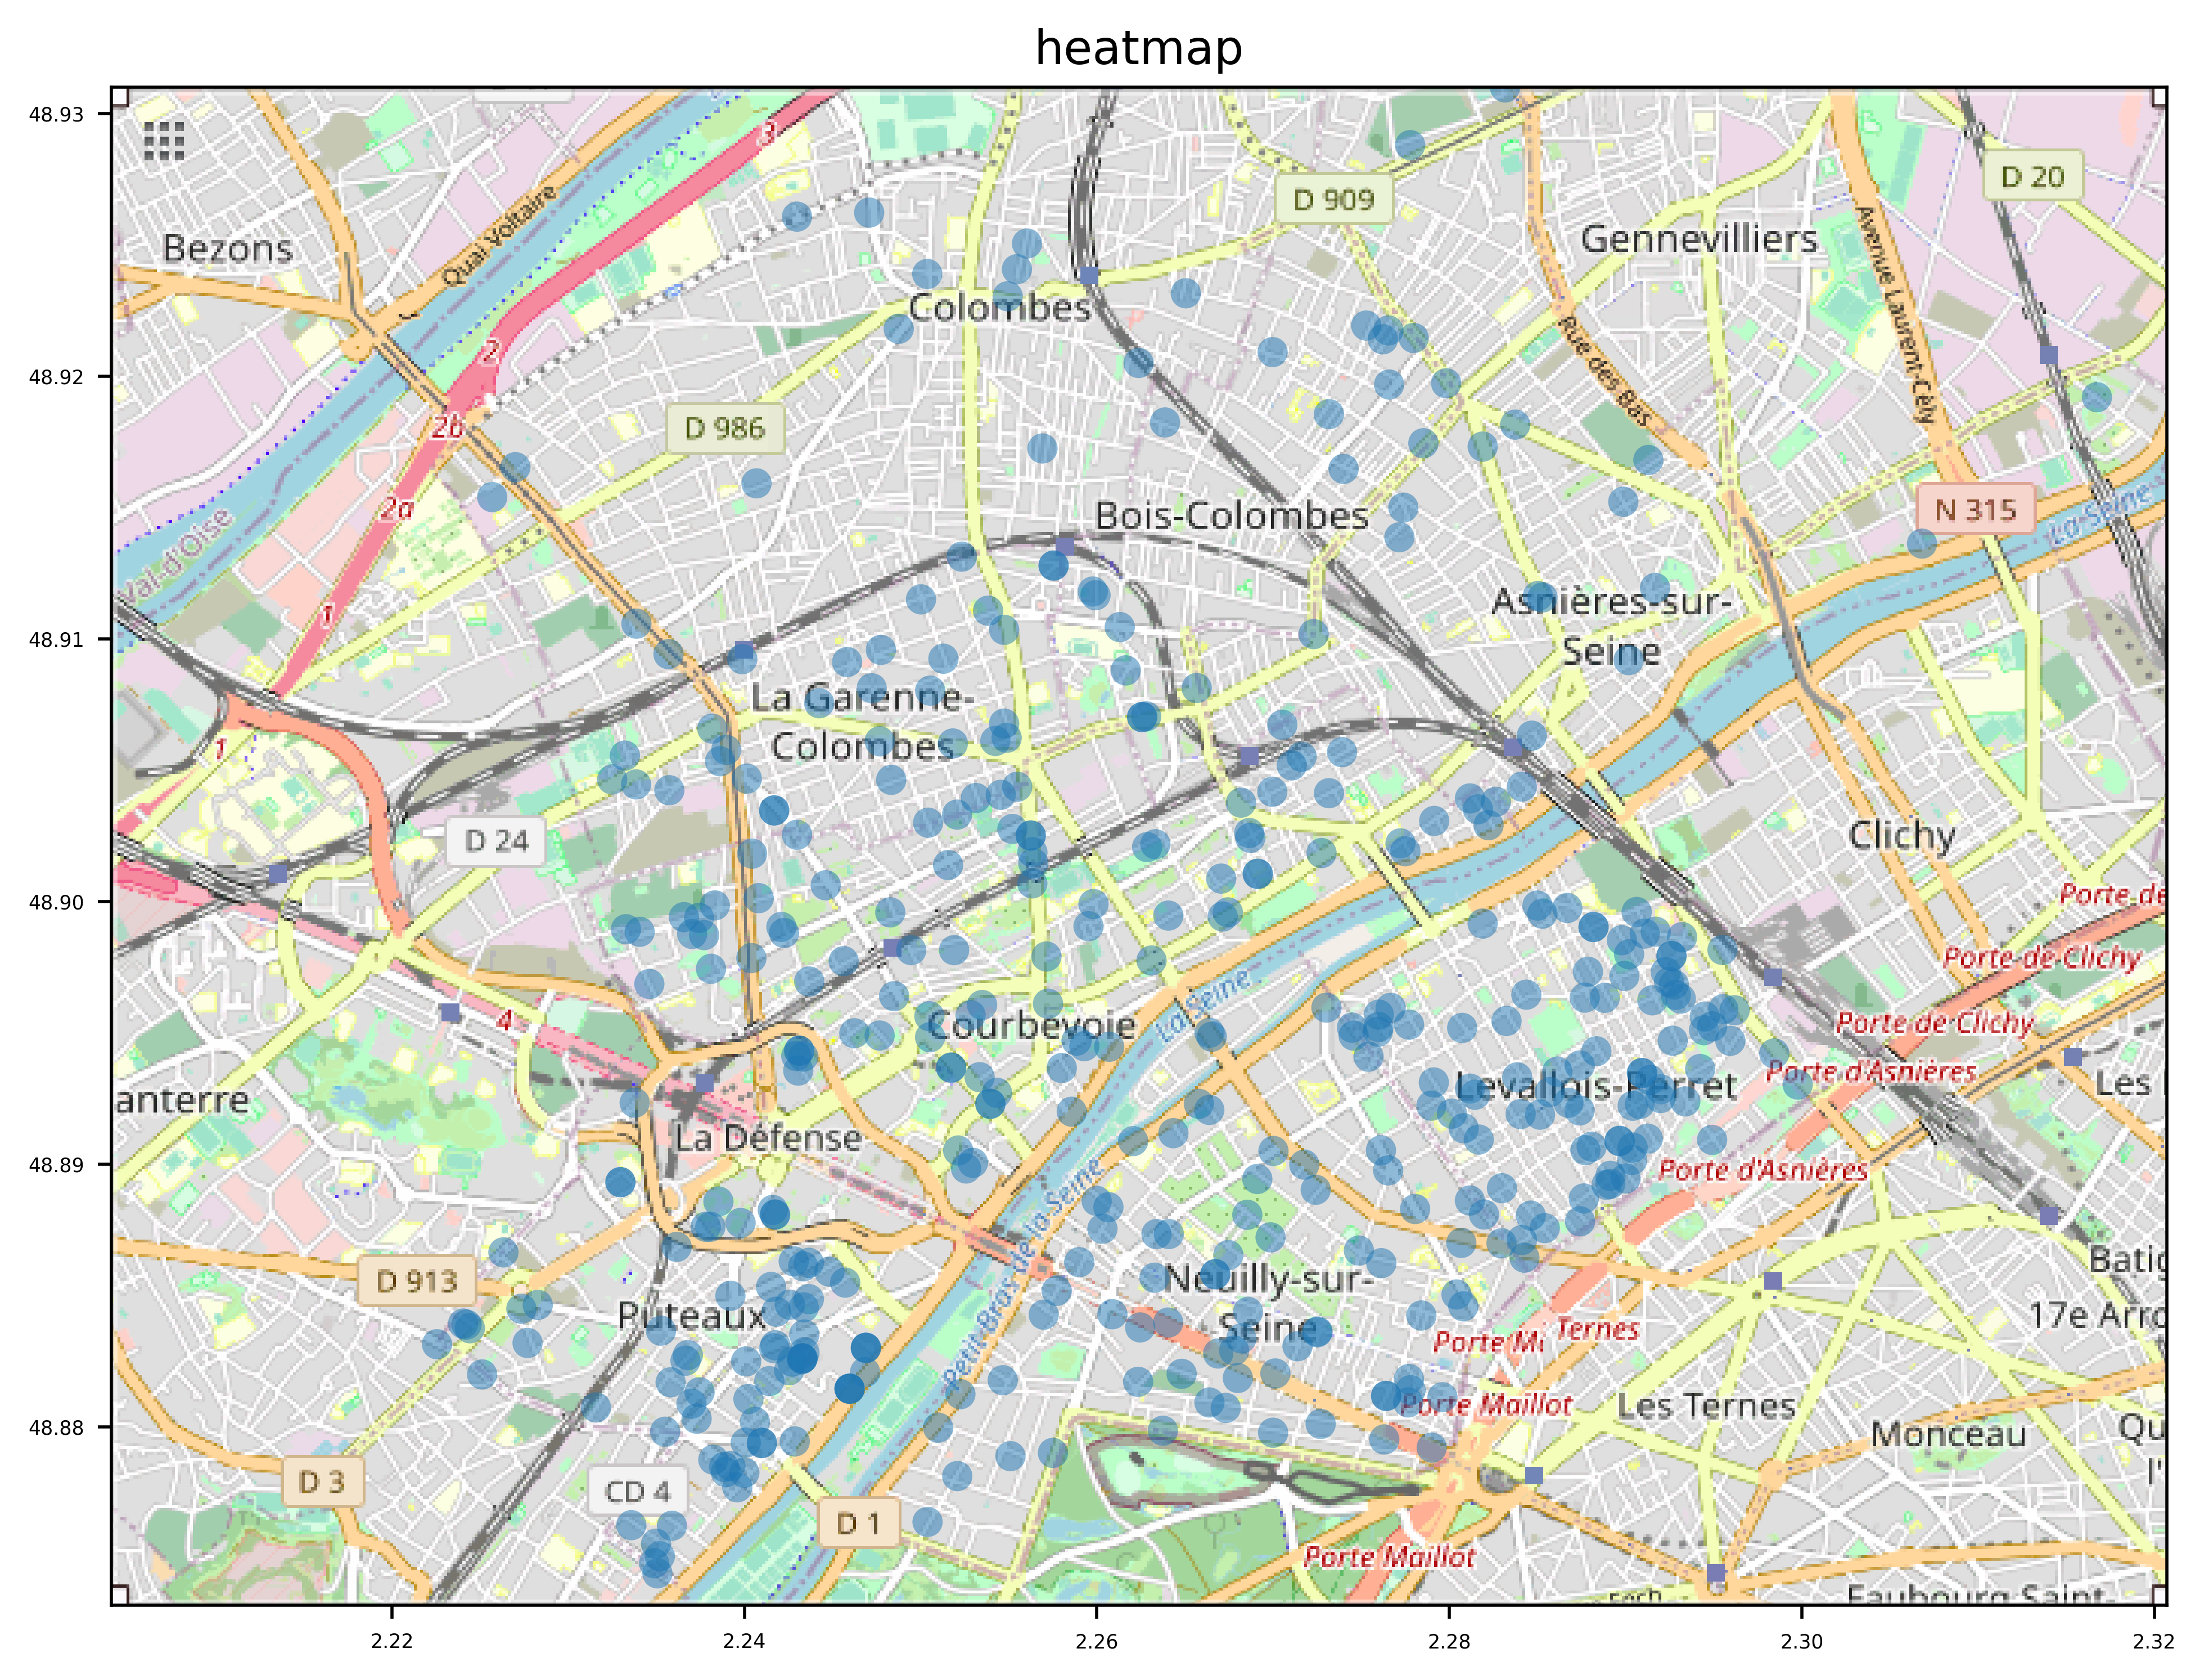

In [23]:
# 48,8732 // 48,9310
# 2.2041 // 2.3207

img=mpimg.imread("map.PNG")

cmap          = matplotlib.cm.get_cmap('YlOrRd')
my_cmap       = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap       = matplotlib.colors.ListedColormap(my_cmap)

x_min = 2.2041 #min(df['long']) - 0.100
x_max = 2.3207 #max(df['long']) + 0.100
y_min = 48.8732 #min(df['lat']) - 0.100
y_max = 48.9310 #max(df['lat']) + 0.100

extent = (x_min, x_max, y_min, y_max)

plt.Figure(figsize=(679,515), dpi=50);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9.43,7.15)
fig.set_dpi(500)
ax = plt.gca()
ax.set_aspect('auto')
plt.title('heatmap');

plt.imshow(img, aspect='auto', extent = extent, cmap='gray') # Comment to remove background

plt.scatter(df['long'], df['lat'], s=60, alpha=0.5, edgecolors='none') # COMMENT TO REMOVE BLUE POINTS
#plt.scatter(df['long'], df['lat'], s=15, alpha=1, edgecolors='none') # COMMENT TO REMOVE ORANGE POINTS
    
plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))

plt.xticks(size=5)
plt.yticks(size=5)

colormap = np.array(['r', 'g', 'b'])

#plt.scatter(a[0], a[1], s=100, c=colormap[df['mean_price_sqrtmtr']])

#plt.savefig(path + '/heatmaps/' + 'global.png' , transparent=True);
plt.show()
#plt.close()# Mapping

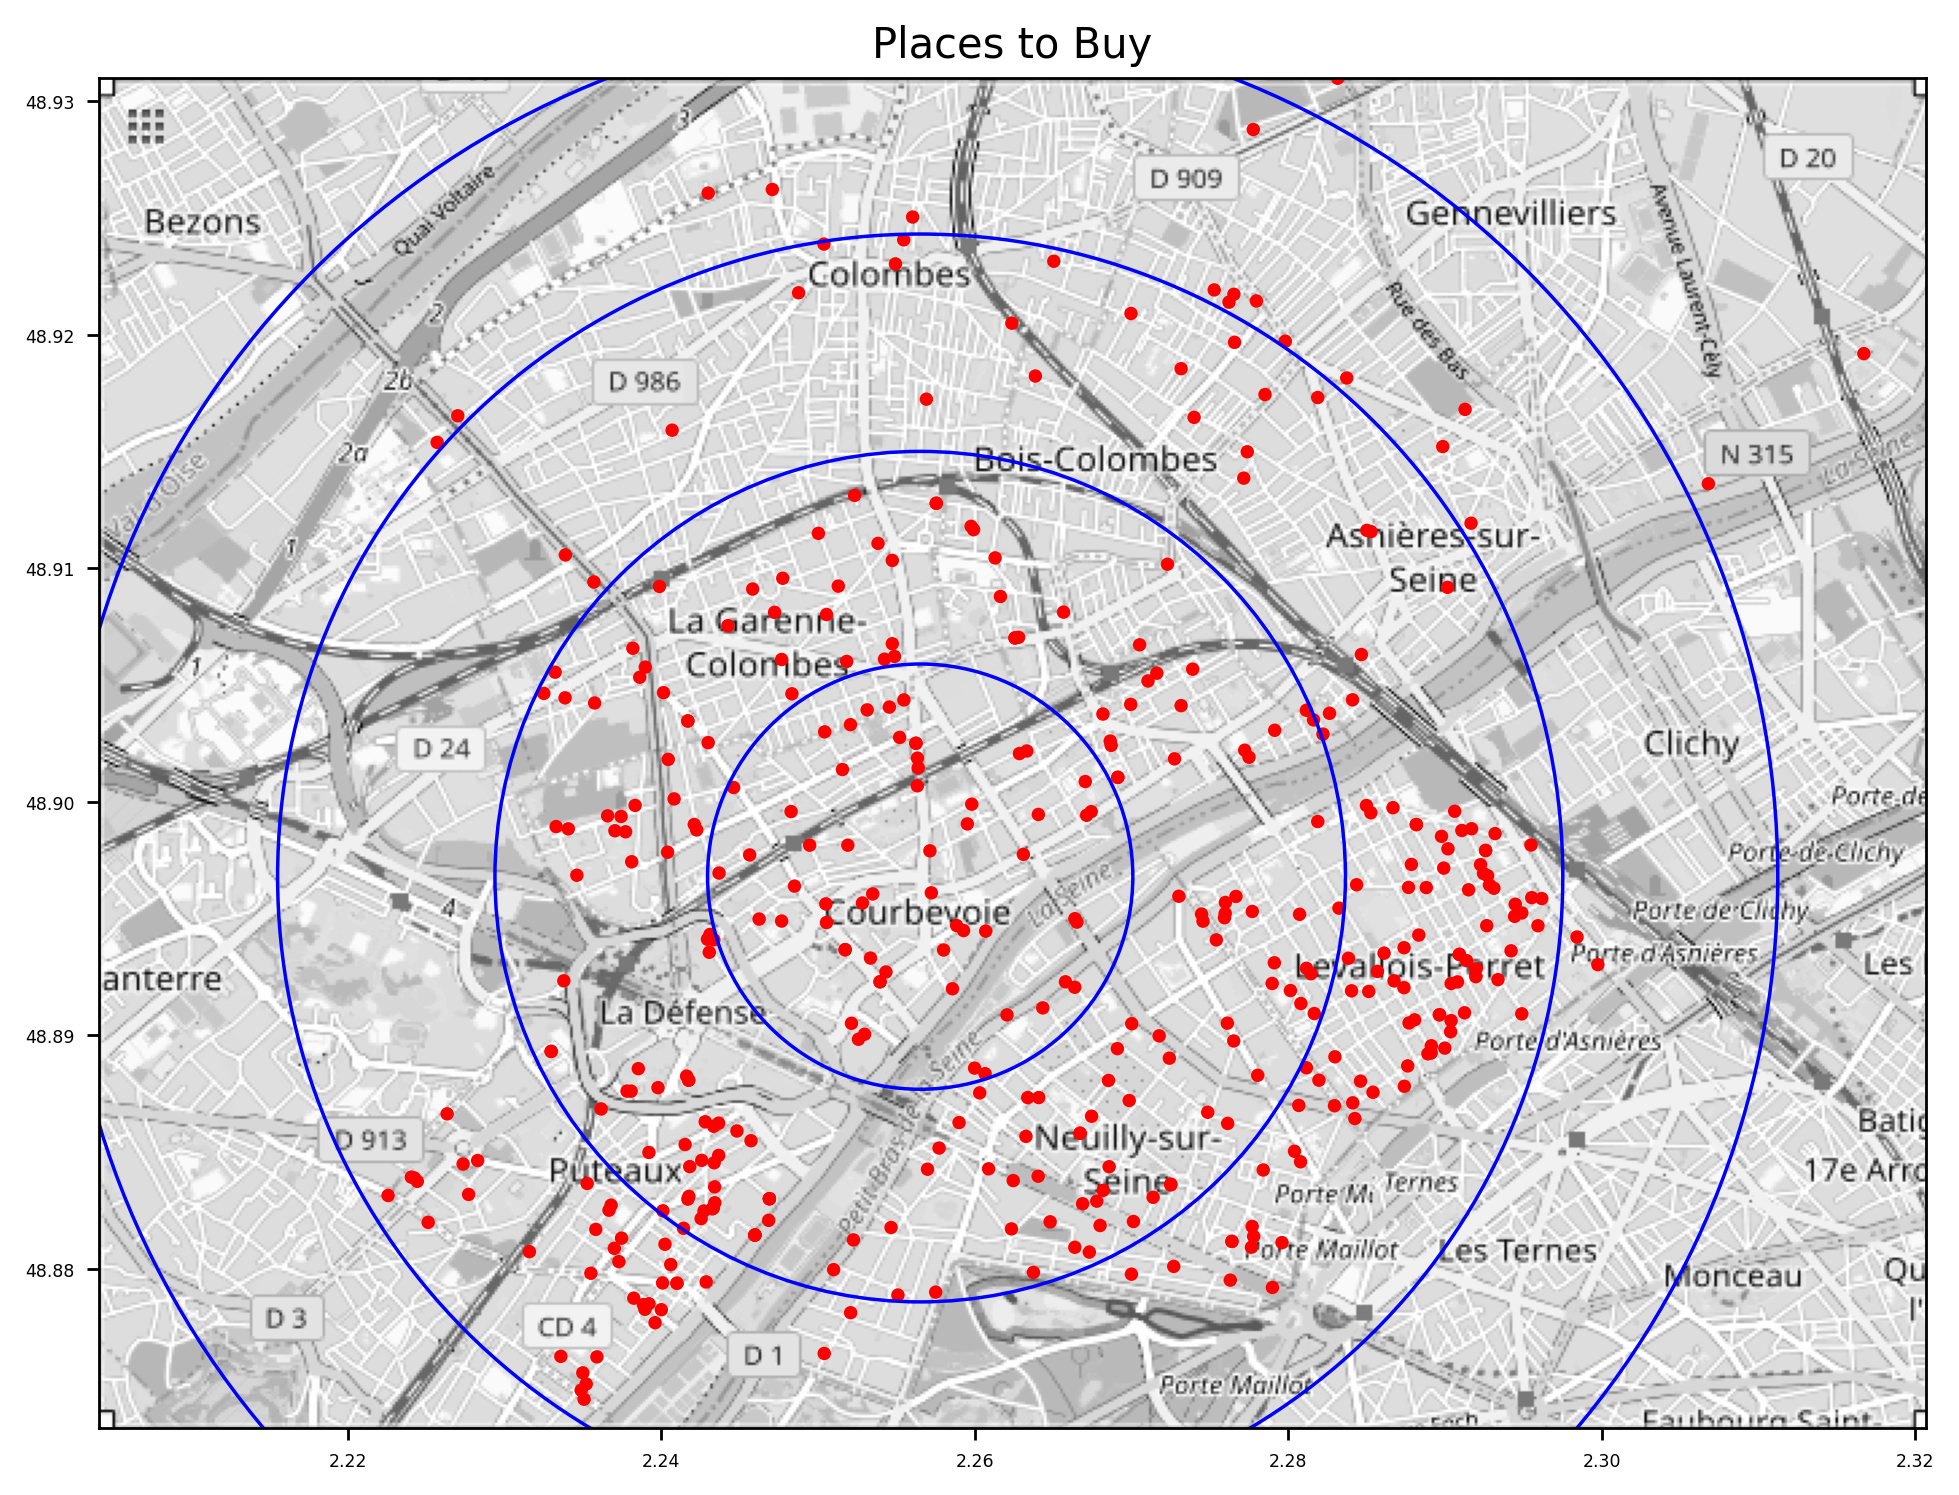

In [24]:
img=mpimg.imread("map.PNG")

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

gray = rgb2gray(img)

x_min = 2.2041 #min(df['long']) - 0.100
x_max = 2.3207 #max(df['long']) + 0.100
y_min = 48.8732 #min(df['lat']) - 0.100
y_max = 48.9310 #max(df['lat']) + 0.100

extent = (x_min, x_max, y_min, y_max)

plt.Figure(figsize=(679,515), dpi=50);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9.43,7.15)
fig.set_dpi(250)
ax = plt.gca()
ax.set_aspect('auto')
plt.title('Places to Buy');

plt.imshow(gray, aspect='auto', extent = extent, cmap = plt.get_cmap('gray')) # Comment to remove background

plt.scatter(df['long'], df['lat'], s=15, alpha=1, edgecolors='none', c='red') # COMMENT TO REMOVE BLACK POINTS

plt.scatter(2.256520, 48.896801, s=244000, c='none', edgecolors='blue') # 4km_Radius
plt.scatter(2.256520, 48.896801, s=137000, c='none', edgecolors='blue') # 3km_Radius
plt.scatter(2.256520, 48.896801, s=60000, c='none', edgecolors='blue') # 2km_Radius
plt.scatter(2.256520, 48.896801, s=15000, c='none', edgecolors='blue') # 1km_Radius

#plt.scatter(2.311173, 48.897086, s=15, c='red', edgecolors='none') # 4km_Point
#plt.scatter(2.297494, 48.897008, s=15, c='red', edgecolors='none') # 3km_Point
#plt.scatter(2.283816, 48.896928, s=15, c='red', edgecolors='none') # 2km_Point
#plt.scatter(2.270135, 48.896850, s=15, c='red', edgecolors='none') # 1km_Point

# 1km = 48.896850, 2.270135
# 2km = 48.896928, 2.283816
# 3km = 48.897008, 2.297494
# 4km = 48.897086, 2.311173

plt.xlim((x_min,x_max))
plt.ylim((y_min,y_max))

plt.xticks(size=5)
plt.yticks(size=5)

#plt.savefig(path + '/heatmaps/' + 'global.png' , transparent=True);
plt.show()
#plt.close()

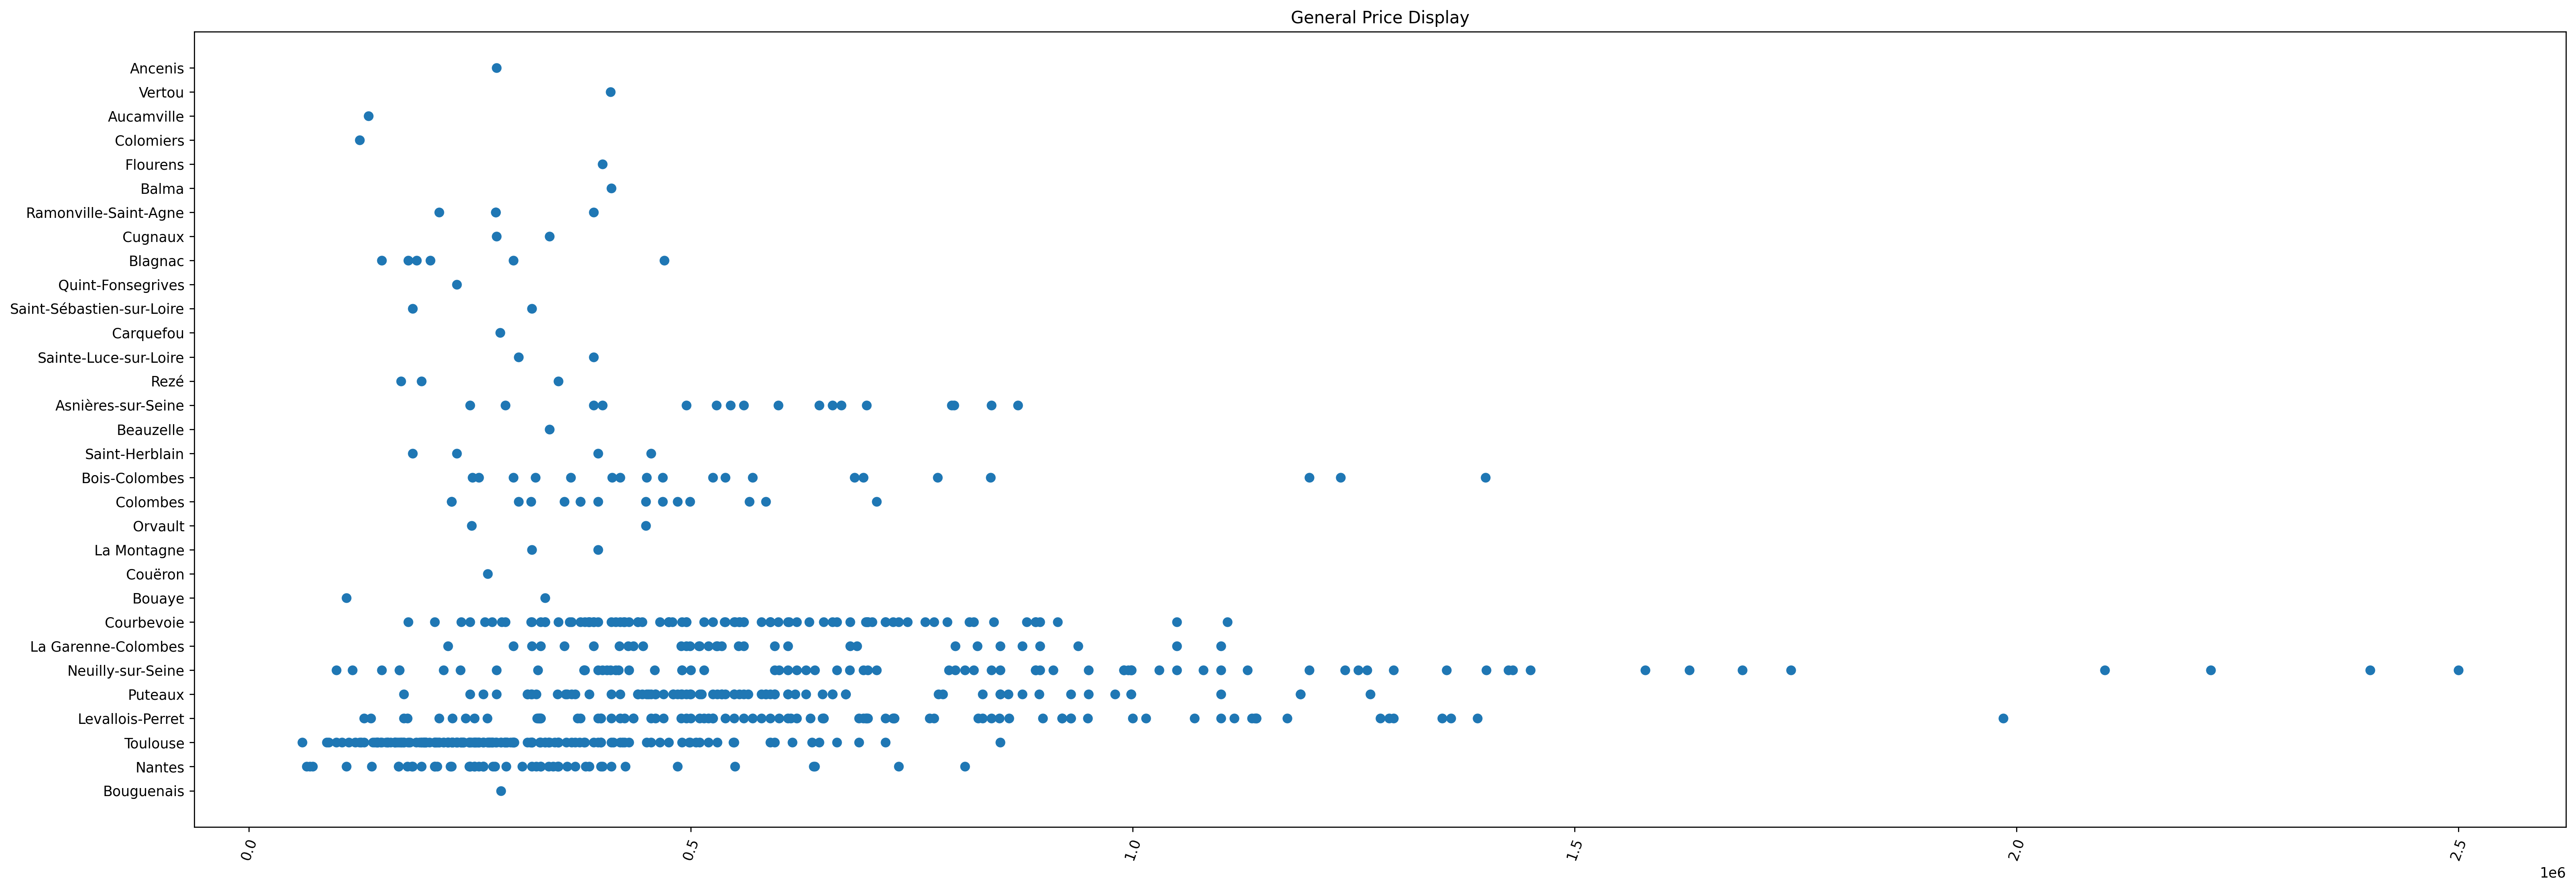

In [25]:
fig = plt.gcf()
fig.set_size_inches(30.5, 10.5)
fig.set_dpi(250)
plt.title("General Price Display")
plt.xticks(rotation=70)
plt.scatter(df['price'], df['city'])

plt.show()

In [26]:
# Predicition Model

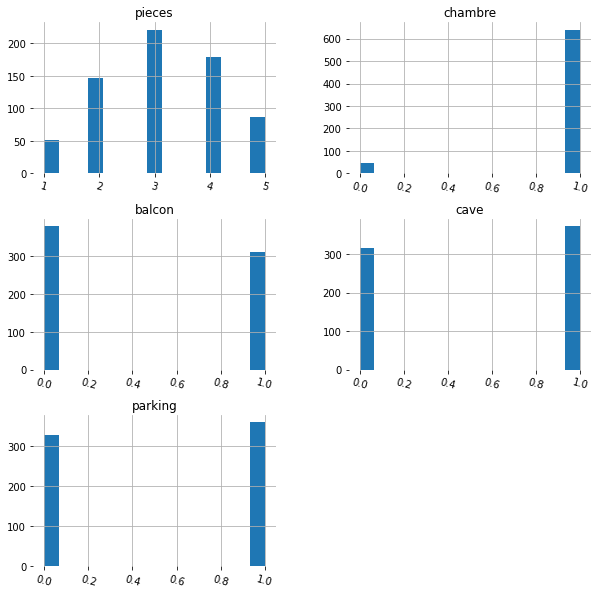

In [27]:
df1=df[['pieces', 'chambre', 'balcon', 'cave', 'parking']]
h = df1.hist(bins=15,figsize=(10,10),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

In [28]:
# Estimation per city

In [29]:
estimation_city = pd.DataFrame({
    "City" : [],
    "sqrt_meter" : [],
    "price" : [],
    "Average Price" : [],
    "Intercept" : [],
    "Coefficient" : []
})

Text(0.5, 0, 'Surface en m2')

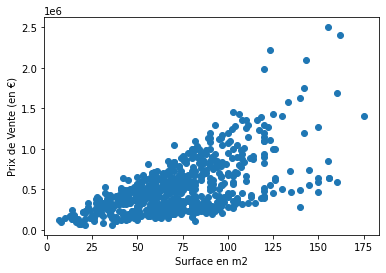

In [30]:
plt.scatter(df['sqrt_meter'], df['price'])

plt.ylabel("Prix de Vente (en €)")
plt.xlabel("Surface en m2")

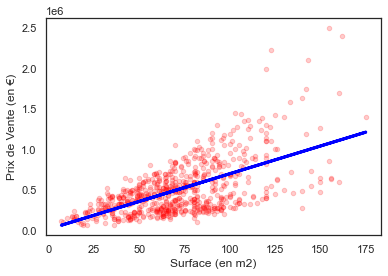

Estimation : 356207.06994388765
Average Price for Test Data: 505333.823
Intercept: 14300.891995989485
Coefficient: 6838.123558957964


In [31]:
# Exemple Explicatif du fonctionnement de LinearRegression()

x2 = df['sqrt_meter'].to_list()
x1 = [1]*len(df)

X = np.column_stack((x1,x2))

y = df['price'].to_list()

def predict_get_value(i) :
    r = regr.predict([[1,i]])
    
    return r[-1]

regr = linear_model.LinearRegression()
regr.fit(X, y)
predict_line = regr.predict(X) #[[1,220]]

sns.set(style="white", font_scale=1)

plt.scatter(x2, y, color='red', s=20, marker='o', alpha=.2)
plt.plot(x2, predict_line, color='blue', linewidth=3)
plt.xlabel("Surface (en m2)")
plt.ylabel("Prix de Vente (en €)")
plt.show()

print('Estimation : {}'.format(predict_get_value(50))) # Obtention de la valeur pour un métrage spécifique
print ("Average Price for Test Data: {:.3f}".format(df['price'].mean()))
print('Intercept: {}'.format(regr.intercept_))
print('Coefficient: {}'.format(regr.coef_[1]))

r = estimation_city.shape[0]
estimation_city.loc[r] = ['General','50',predict_get_value(20),df['price'].mean(),regr.intercept_,regr.coef_[1]]

In [32]:
city_list = df['city'].unique()
city_list

array(['Bouguenais', 'Nantes', 'Toulouse', 'Levallois-Perret', 'Puteaux',
       'Neuilly-sur-Seine', 'La Garenne-Colombes', 'Courbevoie', 'Bouaye',
       'Couëron', 'La Montagne', 'Orvault', 'Colombes', 'Bois-Colombes',
       'Saint-Herblain', 'Beauzelle', 'Asnières-sur-Seine', 'Rezé',
       'Sainte-Luce-sur-Loire', 'Carquefou', 'Saint-Sébastien-sur-Loire',
       'Quint-Fonsegrives', 'Blagnac', 'Cugnaux', 'Ramonville-Saint-Agne',
       'Balma', 'Flourens', 'Colomiers', 'Aucamville', 'Vertou',
       'Ancenis'], dtype=object)

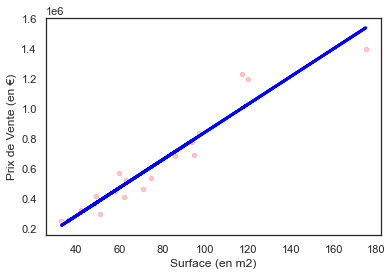

Bois-Colombes
Estimation : 103654.20173410128
Average Price for Test Data: 616578.947
Intercept: -81622.79763951234
Coefficient: 9263.84996868068


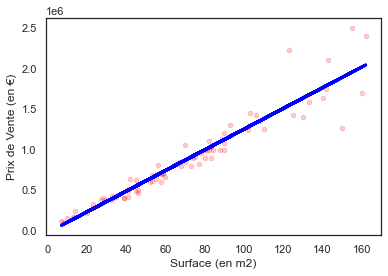

Neuilly-sur-Seine
Estimation : 228668.97565647334
Average Price for Test Data: 871549.067
Intercept: -26577.22246827255
Coefficient: 12762.309906237295


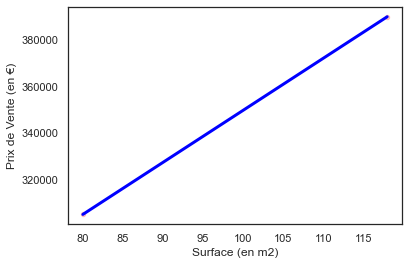

Sainte-Luce-sur-Loire
Estimation : 170789.4736842106
Average Price for Test Data: 347500.000
Intercept: 126052.63157894745
Coefficient: 2236.842105263157


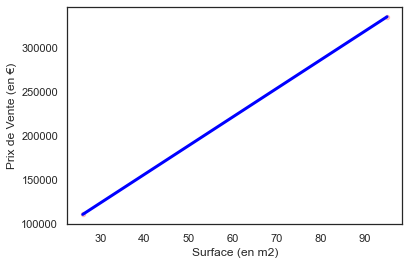

Bouaye
Estimation : 90434.78260869568
Average Price for Test Data: 222500.000
Intercept: 25217.391304347868
Coefficient: 3260.8695652173906


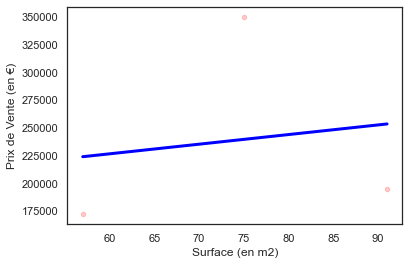

Rezé
Estimation : 191865.2073732719
Average Price for Test Data: 239000.000
Intercept: 174514.97695852537
Coefficient: 867.5115207373268


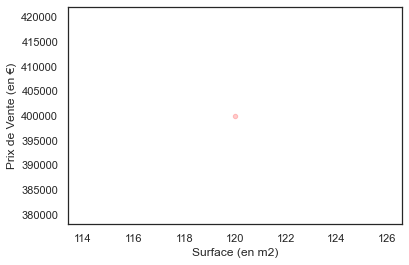

Flourens
Estimation : 400000.0
Average Price for Test Data: 400000.000
Intercept: 400000.0
Coefficient: 0.0


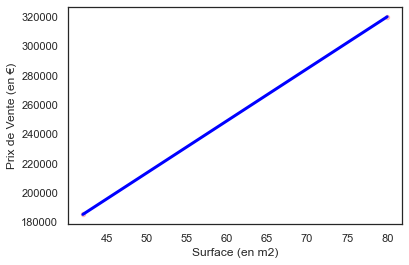

Saint-Sébastien-sur-Loire
Estimation : 106842.10526315798
Average Price for Test Data: 252500.000
Intercept: 35789.47368421065
Coefficient: 3552.6315789473665


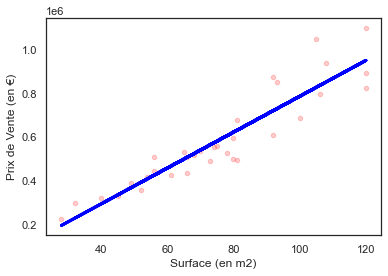

La Garenne-Colombes
Estimation : 130868.61090075132
Average Price for Test Data: 584363.636
Intercept: -33045.25372438785
Coefficient: 8195.693231256959


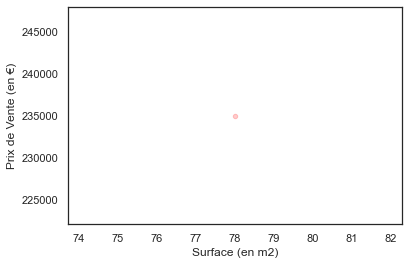

Quint-Fonsegrives
Estimation : 235000.0
Average Price for Test Data: 235000.000
Intercept: 235000.0
Coefficient: 0.0


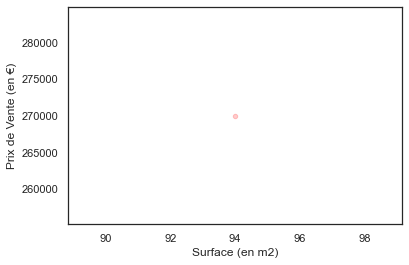

Couëron
Estimation : 270000.0
Average Price for Test Data: 270000.000
Intercept: 270000.0
Coefficient: 0.0


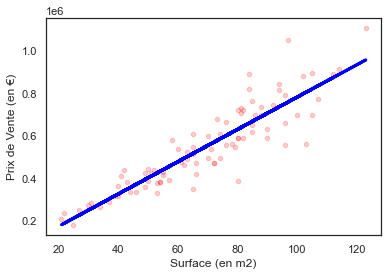

Courbevoie
Estimation : 175474.82325488416
Average Price for Test Data: 547698.864
Intercept: 23863.087297604885
Coefficient: 7580.586797863964


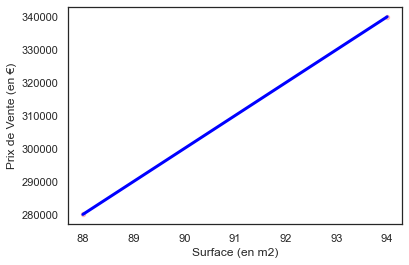

Cugnaux
Estimation : -399999.9999999997
Average Price for Test Data: 310000.000
Intercept: -599999.9999999997
Coefficient: 9999.999999999996


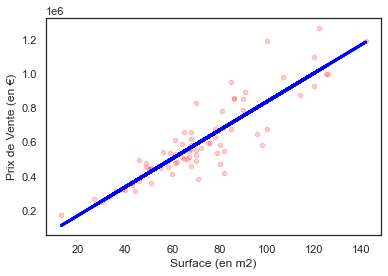

Puteaux
Estimation : 170026.6108336558
Average Price for Test Data: 586746.835
Intercept: 3507.1482937408146
Coefficient: 8325.97312699575


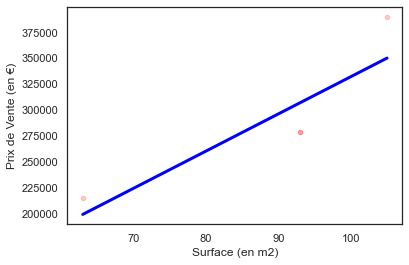

Ramonville-Saint-Agne
Estimation : 44384.7352024922
Average Price for Test Data: 290750.000
Intercept: -27546.728971962642
Coefficient: 3596.573208722742


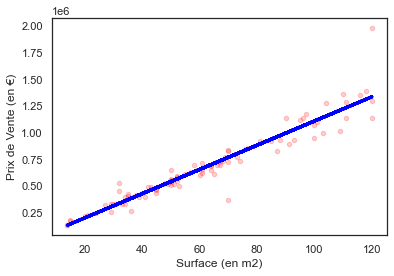

Levallois-Perret
Estimation : 200396.68949507386
Average Price for Test Data: 679355.556
Intercept: -26897.262234129128
Coefficient: 11364.69758646015


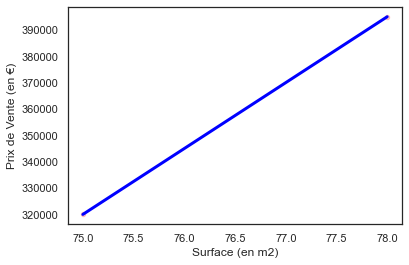

La Montagne
Estimation : -1054999.9999999993
Average Price for Test Data: 357500.000
Intercept: -1554999.999999999
Coefficient: 24999.99999999999


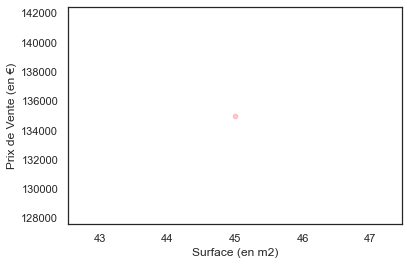

Aucamville
Estimation : 135000.0
Average Price for Test Data: 135000.000
Intercept: 135000.0
Coefficient: 0.0


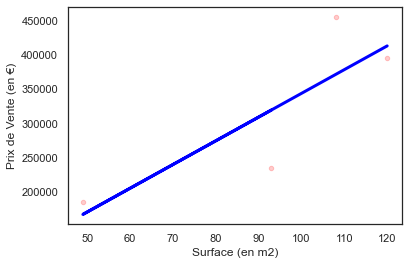

Saint-Herblain
Estimation : 66924.54136379353
Average Price for Test Data: 317500.000
Intercept: -2199.7230875737732
Coefficient: 3456.213222568365


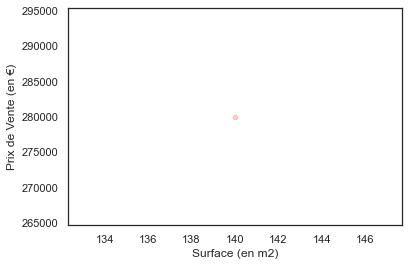

Ancenis
Estimation : 280000.0
Average Price for Test Data: 280000.000
Intercept: 280000.0
Coefficient: 0.0


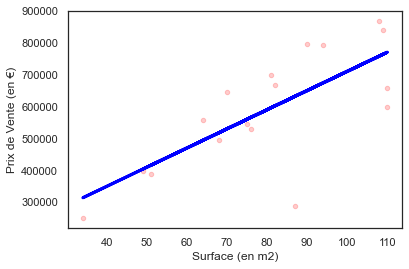

Asnières-sur-Seine
Estimation : 230665.45215540033
Average Price for Test Data: 590294.118
Intercept: 110553.71711889358
Coefficient: 6005.586751825338


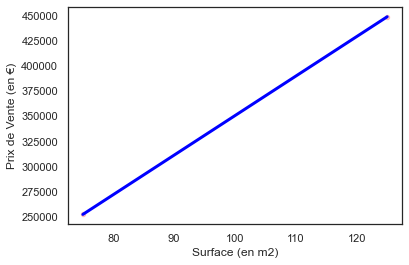

Orvault
Estimation : 35300.0000000001
Average Price for Test Data: 350500.000
Intercept: -43499.99999999988
Coefficient: 3939.999999999999


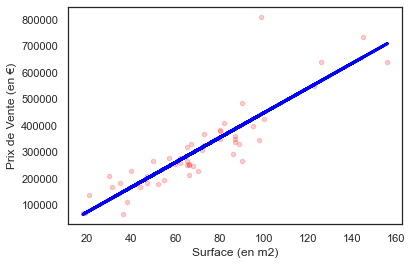

Nantes
Estimation : 74331.83823312249
Average Price for Test Data: 309978.846
Intercept: -18958.18393572129
Coefficient: 4664.5011084421885


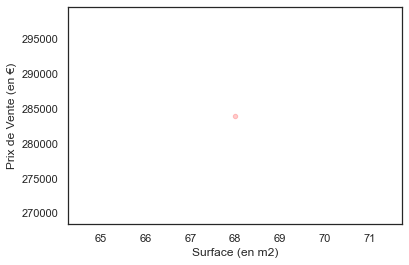

Carquefou
Estimation : 284000.0
Average Price for Test Data: 284000.000
Intercept: 284000.0
Coefficient: 0.0


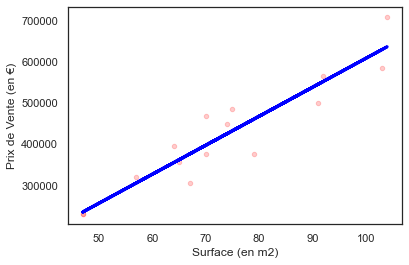

Colombes
Estimation : 44452.04376234635
Average Price for Test Data: 423066.667
Intercept: -96646.57346907735
Coefficient: 7054.930861571185


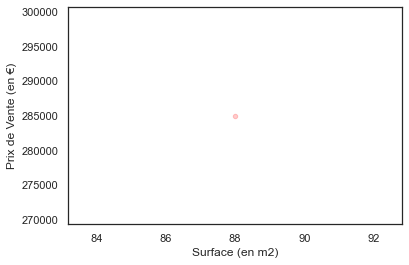

Bouguenais
Estimation : 285000.0
Average Price for Test Data: 285000.000
Intercept: 285000.0
Coefficient: 0.0


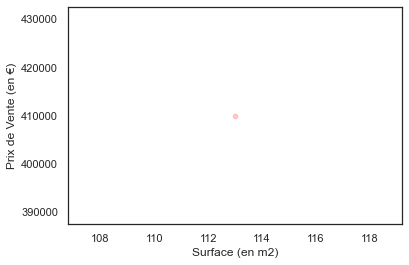

Balma
Estimation : 410000.0
Average Price for Test Data: 410000.000
Intercept: 410000.0
Coefficient: 0.0


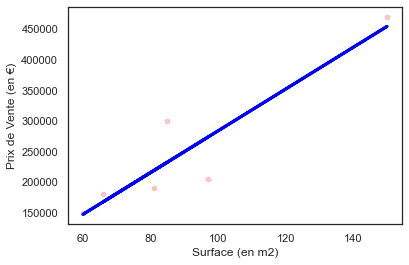

Blagnac
Estimation : 10434.220168870495
Average Price for Test Data: 248916.667
Intercept: -57866.24183527162
Coefficient: 3415.0231002071055


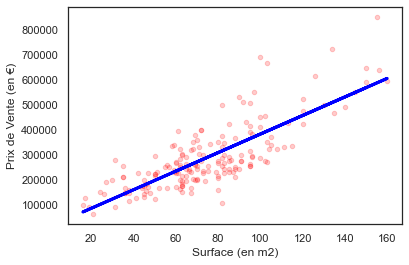

Toulouse
Estimation : 84527.5479493199
Average Price for Test Data: 286747.722
Intercept: 10356.113677037822
Coefficient: 3708.5717136141034


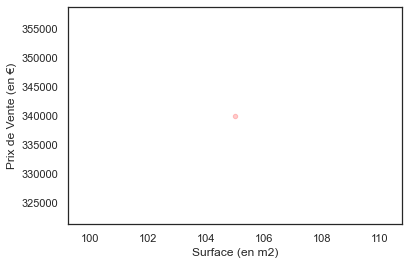

Beauzelle
Estimation : 340000.0
Average Price for Test Data: 340000.000
Intercept: 340000.0
Coefficient: 0.0


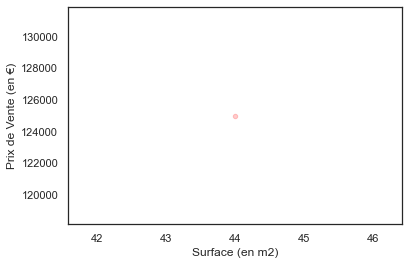

Colomiers
Estimation : 125000.0
Average Price for Test Data: 125000.000
Intercept: 125000.0
Coefficient: 0.0


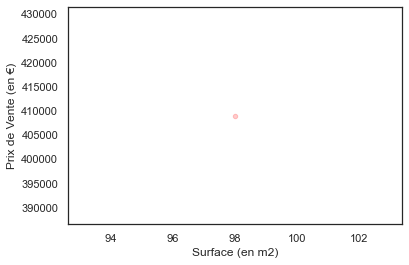

Vertou
Estimation : 409000.0
Average Price for Test Data: 409000.000
Intercept: 409000.0
Coefficient: 0.0


In [33]:
for city_id in set(df['city']):
    df_filtered = df.loc[df['city']==city_id,:] 


    x2 = df_filtered['sqrt_meter'].to_list()
    x1 = [1]*len(df_filtered)

    X = np.column_stack((x1,x2))

    y = df_filtered['price'].to_list()

    def predict_get_value(i) :
        r = regr.predict([[1,i]])
    
        return r[-1]

    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    predict_line = regr.predict(X) #[[1,220]]

    sns.set(style="white", font_scale=1)

    plt.scatter(x2, y, color='red', s=20, marker='o', alpha=.2)
    plt.plot(x2, predict_line, color='blue', linewidth=3)
    plt.xlabel("Surface (en m2)")
    plt.ylabel("Prix de Vente (en €)")
    plt.show()

    print(city_id)
    print('Estimation : {}'.format(predict_get_value(20))) # Obtention de la valeur pour un métrage spécifique
    print ("Average Price for Test Data: {:.3f}".format(df_filtered['price'].mean()))
    print('Intercept: {}'.format(regr.intercept_))
    print('Coefficient: {}'.format(regr.coef_[1]))

    r = estimation_city.shape[0]
    estimation_city.loc[r] = [city_id,'20',predict_get_value(20),df_filtered['price'].mean(),regr.intercept_,regr.coef_[1]]

In [34]:
estimation_city

City sqrt_meter         price  Average Price  \
0                     General         50  1.510634e+05  505333.822674   
1               Bois-Colombes         20  1.036542e+05  616578.947368   
2           Neuilly-sur-Seine         20  2.286690e+05  871549.066667   
3       Sainte-Luce-sur-Loire         20  1.707895e+05  347500.000000   
4                      Bouaye         20  9.043478e+04  222500.000000   
5                        Rezé         20  1.918652e+05  239000.000000   
6                    Flourens         20  4.000000e+05  400000.000000   
7   Saint-Sébastien-sur-Loire         20  1.068421e+05  252500.000000   
8         La Garenne-Colombes         20  1.308686e+05  584363.636364   
9           Quint-Fonsegrives         20  2.350000e+05  235000.000000   
10                    Couëron         20  2.700000e+05  270000.000000   
11                 Courbevoie         20  1.754748e+05  547698.863636   
12                    Cugnaux         20 -4.000000e+05  310000.000000   
13                    Puteaux         20  1.700266e+05  586746.835443   
14      Ramonville-Saint-Agne         20  4.438474e+04  290750.000000   
15           Levallois-Perret         20  2.003967e+05  679355.555556   
16                La Montagne         20 -1.055000e+06  357500.000000   
17                 Aucamville         20  1.350000e+05  135000.000000   
18             Saint-Herblain         20  6.692454e+04  317500.000000   
19                    Ancenis         20  2.800000e+05  280000.000000   
20         Asnières-sur-Seine         20  2.306655e+05  590294.117647   
21                    Orvault         20  3.530000e+04  350500.000000   
22                     Nantes         20  7.433184e+04  309978.846154   
23                  Carquefou         20  2.840000e+05  284000.000000   
24                   Colombes         20  4.445204e+04  423066.666667   
25                 Bouguenais         20  2.850000e+05  285000.000000   
26                      Balma         20  4.100000e+05  410000.000000   
27                    Blagnac         20  1.043422e+04  248916.666667   
28                   Toulouse         20  8.452755e+04  286747.722222   
29                  Beauzelle         20  3.400000e+05  340000.000000   
30                  Colomiers         20  1.250000e+05  125000.000000   
31                     Vertou         20  4.090000e+05  409000.000000   

       Intercept   Coefficient  
0   1.430089e+04   6838.123559  
1  -8.162280e+04   9263.849969  
2  -2.657722e+04  12762.309906  
3   1.260526e+05   2236.842105  
4   2.521739e+04   3260.869565  
5   1.745150e+05    867.511521  
6   4.000000e+05      0.000000  
7   3.578947e+04   3552.631579  
8  -3.304525e+04   8195.693231  
9   2.350000e+05      0.000000  
10  2.700000e+05      0.000000  
11  2.386309e+04   7580.586798  
12 -6.000000e+05  10000.000000  
13  3.507148e+03   8325.973127  
14 -2.754673e+04   3596.573209  
15 -2.689726e+04  11364.697586  
16 -1.555000e+06  25000.000000  
17  1.350000e+05      0.000000  
18 -2.199723e+03   3456.213223  
19  2.800000e+05      0.000000  
20  1.105537e+05   6005.586752  
21 -4.350000e+04   3940.000000  
22 -1.895818e+04   4664.501108  
23  2.840000e+05      0.000000  
24 -9.664657e+04   7054.930862  
25  2.850000e+05      0.000000  
26  4.100000e+05      0.000000  
27 -5.786624e+04   3415.023100  
28  1.035611e+04   3708.571714  
29  3.400000e+05      0.000000  
30  1.250000e+05      0.000000  
31  4.090000e+05      0.000000

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


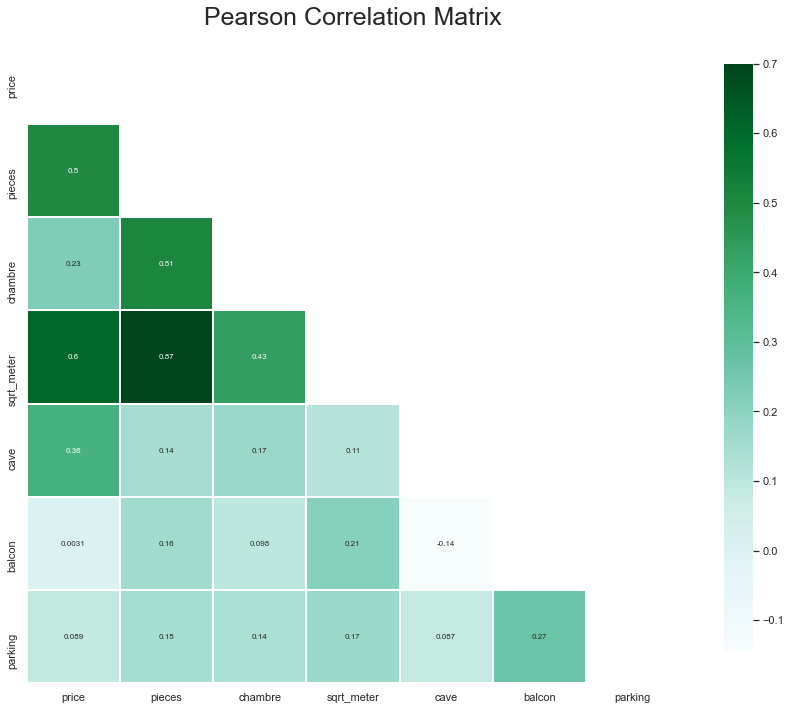

In [35]:
features = ['price','pieces','chambre','sqrt_meter','cave','balcon','parking']

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [36]:
df.head()

title  \
0    Vente maison 88 m² Bouguenais (44340) 285.000 €   
1  Vente appartement 3 pièces 66 m² Nantes (44000...   
2  Vente appartement 2 pièces 62 m² Nantes (44000...   
3  Vente appartement 3 pièces 57 m² Nantes (44000...   
4  Vente appartement 3 pièces 89 m² Nantes (44000...   

                                                link   price        city  \
0  https://www.pap.fr/annonces/maison-bouguenais-...  285000  Bouguenais   
1  https://www.pap.fr/annonces/appartement-nantes...  250000      Nantes   
2  https://www.pap.fr/annonces/appartement-nantes...  260000      Nantes   
3  https://www.pap.fr/annonces/appartement-nantes...  276000      Nantes   
4  https://www.pap.fr/annonces/appartement-nantes...  400000      Nantes   

                                           free_text  transport  \
0  Bouguenais (44340) 4 pièces 3 chambres 88 m² T...        NaN   
1  Nantes (44000) 3 pièces 2 chambres 66 m² 3.788...        NaN   
2  Nantes (44000) 2 pièces 1 chambre 62 m² 4.194 ...        NaN   
3  Nantes (44000) 3 pièces 2 chambres 57 m² 4.842...        NaN   
4  Nantes (44000) 3 pièces 2 chambres 89 m² 4.494...        NaN   

                    createdAt                   updatedAt        lat  \
0  2021-06-29 22:54:11.826+02  2021-06-29 22:54:11.826+02  47.164128   
1  2021-06-29 22:49:15.028+02  2021-06-29 22:49:15.028+02   0.000000   
2  2021-06-29 22:49:10.891+02  2021-06-29 22:49:10.891+02  47.221568   
3  2021-06-29 22:49:06.735+02  2021-06-29 22:49:06.735+02  47.222167   
4  2021-06-29 22:48:58.579+02  2021-06-29 22:48:58.579+02  47.218043   

       long  ...        date pieces  chambre  sqrt_meter  mean_price_sqrtmtr  \
0 -1.572820  ...  26/06/2021    4.0        1          88         3238.636364   
1  0.000000  ...  29/06/2021    3.0        1          66         3787.878788   
2 -1.566400  ...  29/06/2021    2.0        1          62         4193.548387   
3 -1.556663  ...  29/06/2021    3.0        1          57         4842.105263   
4 -1.548062  ...  29/06/2021    3.0        1          89         4494.382022   

   cave  balcon  parking     distance  code-postal  
0     0       1        0   467.346549        44340  
1     1       1        1  5441.385126        44000  
2     0       0        0   464.097038        44000  
3     1       0        1   463.078795        44000  
4     0       1        0   462.388151        44000  

[5 rows x 21 columns]

In [37]:
df['free_text'][0]

"Bouguenais (44340) 4 pièces 3 chambres 88\xa0m² Terrain 330\xa0m² 3.239 € le m² Voir l'adresse du bien sur une carte Maison de 88m2 de 1999 dont une extension de 2012. Situé à 2 km du centre de Bouguenais les Couets (Tram, écoles, commerces) et Leclerc Océane. Pièce de vie de 32m W à chaque étage 3 chambres à l’étage : - 9m avec placards - 12m avec placards - 10m sans placard + un dressing de 9m pouvant servir de bureau Salle de bains avec douche et baignoire + doubles vasques Petit jardin de 60m avec terrasse neuve + seconde parcelle non attenante Chauffage poêle à granulés installé en 2017 et électrique. Maison de 88m2 de 1999 dont une extension de 2012. Situé à 2 km du centre de Bouguenais les Couets (Tram, écoles, commerces) et Leclerc Océane. Pièce de vie de 32m W à chaque étage 3 chambres à l’étage : - 9m avec placards - 12m avec placards - 10m sans placard + un dressing de 9m pouvant servir de bureau Salle de bains avec douche et baignoire + doubles vasques Petit jardin de 60m 

In [38]:
df.iloc[0,:]

title                   Vente maison 88 m² Bouguenais (44340) 285.000 €
link                  https://www.pap.fr/annonces/maison-bouguenais-...
price                                                            285000
city                                                         Bouguenais
free_text             Bouguenais (44340) 4 pièces 3 chambres 88 m² T...
transport                                                           NaN
createdAt                                    2021-06-29 22:54:11.826+02
updatedAt                                    2021-06-29 22:54:11.826+02
lat                                                           47.164128
long                                                           -1.57282
ref                                                     Réf. : D80/1598
date                                                         26/06/2021
pieces                                                              4.0
chambre                                                         

In [39]:
# Graph avec les points et toutes les regressions linéaires 
# Regression multiples : Avec impacts : Pieces, size, balcon, cave, parking. [Polynome 5e degré]

In [40]:
test = df.loc[df['city'] == 'Courbevoie', :]
x = test['sqrt_meter'].values
y = test['price'].values
z = test['pieces'].values

Text(0, 0.5, 'Price')

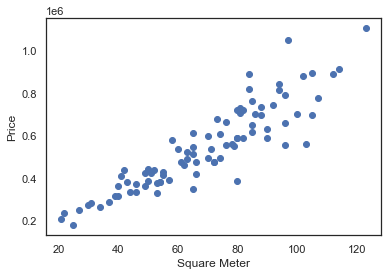

In [41]:
plt.scatter(x, y)
plt.xlabel('Square Meter')
plt.ylabel('Price')

In [42]:
# Vérification des dimensions
print(x.shape)
print(y.shape)

# redimensionner y
x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)
z = z.reshape(z.shape[0], 1)
print(y.shape)

(88,)
(88,)
(88, 1)


In [43]:
# Création de la matrice X, inclus le biais
X = np.hstack((x, np.ones((x.shape[0], 1))))
print(X.shape)
print(X[:10])

(88, 2)
[[60.  1.]
 [65.  1.]
 [51.  1.]
 [55.  1.]
 [21.  1.]
 [50.  1.]
 [96.  1.]
 [65.  1.]
 [40.  1.]
 [80.  1.]]


In [44]:
# Initialisation du vecteur theta aléatoire
theta = np.random.randn(2,1)
theta

array([[ 1.36825515],
       [-1.13383288]])

In [45]:
## Modele linéaire
def model(X, theta):
    return X.dot(theta)

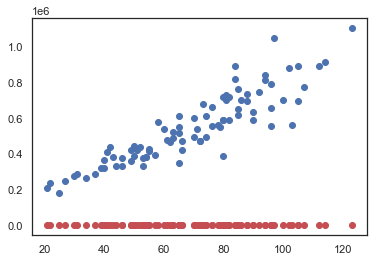

In [46]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], model(X, theta), c='r')

In [47]:
## Fonction Cout : Erreur Quadratique Moyenne

def cost_function(X, y, theta):
    m = len(y)
    return 1/(2*m) * np.sum((model(X, theta) - y)**2)

cost_function(X, y, theta)

169099869145.9943

In [48]:
# Descente de gradient

In [49]:
def grad(X, y, theta):
    m = len(y)
    return 1/m * X.T.dot(model(X, theta) - y)

In [50]:
def gradient_descent(X, y, theta, learning_rate, n_iterations):
    cost_history = np.zeros(n_iterations)
    
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X, y, theta) # Mise à jour de theta
        cost_history[i] = cost_function(X, y, theta) # Enregistrement valeur theta
    
    return theta, cost_history

In [51]:
## Phase d'entrainement

n_iterations = 1000
learning_rate = 0.0001

theta_final, cost_history = gradient_descent(X, y, theta, learning_rate, n_iterations)

theta_final # parametres du model entrainé

array([[7886.51515279],
       [ 340.85984274]])

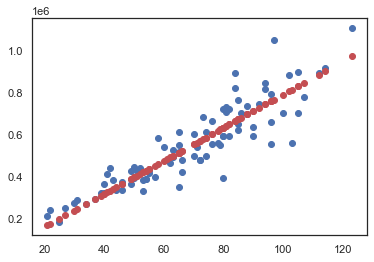

In [52]:
# création d'un vecteur prediction
predictions = model(X, theta_final)

# Afficher resultat prediction
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], predictions, c='r')